一.数据读取与预处理

In [33]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from collections import defaultdict
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import dash
from dash import dcc, html, Input, Output, State, callback


# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 读取数据
print("正在读取数据...")
video_df = pd.read_csv("StructBERT_带情绪标签的文本数据.csv")
comment_df = pd.read_csv("视频评论信息.csv")

print(f"视频数据量: {len(video_df)}")
print(f"评论数据量: {len(comment_df)}")

# 检查列名并调整
print("视频数据列名:", video_df.columns.tolist())

# 2. 数据预处理
video_df['url'] = video_df['url'].astype(str).str.strip()
comment_df['url'] = comment_df['url'].astype(str).str.strip()

# 合并评论数据
comment_counts = comment_df.groupby('url')['评论用户ID'].nunique().reset_index()
comment_counts.columns = ['url', '评论用户数']
video_df = video_df.merge(comment_counts, on='url', how='left')
video_df['评论用户数'] = video_df['评论用户数'].fillna(0)

正在读取数据...


C:\Users\31596\AppData\Local\Temp\ipykernel_9284\4003221976.py:21: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



视频数据量: 505597
评论数据量: 371200
视频数据列名: ['url', 'text', '发布者', 'texttype', 'sentiment_score', 'emotion_label', '点赞量', '播放量', '分享量']


二.原始图表构建(便于节点筛选)

In [34]:
def build_original_network_and_metrics(video_df, comment_df):
    """
    构建原始网络图并计算原始指标表
    
    参数:
    video_df: 视频数据
    comment_df: 评论数据
    
    返回:
    G: 原始网络图
    metrics_df: 原始指标表
    """
    print("\n=== 构建原始网络图与原始指标表 ===")
    
    # 创建空图
    G = nx.Graph()
    
    # 添加视频节点
    print("添加视频节点...")
    for idx, row in video_df.iterrows():
        video_id = f"video_{row['url']}"
        G.add_node(video_id, 
                  node_type='video',
                  emotion_label=row['emotion_label'],
                  sentiment_score=row['sentiment_score'],
                  title=row.get('title', ''),
                  url=row['url'])
    
    # 添加用户节点和边
    print("添加用户节点和边...")
    user_count = 0
    for idx, row in comment_df.iterrows():
        user_id = f"user_{row['评论用户ID']}"
        video_id = f"video_{row['url']}"
        
        # 添加用户节点（如果不存在）
        if user_id not in G:
            G.add_node(user_id, node_type='user')
            user_count += 1
        
        # 添加边（用户-视频关系）
        G.add_edge(user_id, video_id)
    
    print(f"网络构建完成: {G.number_of_nodes()} 个节点, {G.number_of_edges()} 条边")
    print(f"视频节点: {len([n for n in G.nodes() if G.nodes[n]['node_type'] == 'video'])}")
    print(f"用户节点: {len([n for n in G.nodes() if G.nodes[n]['node_type'] == 'user'])}")
    
    # 计算网络指标
    print("计算网络指标...")
    video_nodes = [n for n in G.nodes() if G.nodes[n]['node_type'] == 'video']
    
    # 计算中心性指标
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, k=min(100, len(G.nodes())))
    
    # 计算连通分量
    connected_components = list(nx.connected_components(G))
    largest_component = max(connected_components, key=len) if connected_components else set()
    
    # 计算模块度（社群划分）
    try:
        from community import community_louvain
        partition = community_louvain.best_partition(G)
        modularity = community_louvain.modularity(partition, G)
    except:
        partition = {}
        modularity = 0
        print("注意: 未安装python-louvain库，模块度计算跳过")
    
    # 构建原始指标表
    network_metrics = []
    for node in video_nodes:
        metrics = {
            'node_id': node,
            'emotion_label': G.nodes[node]['emotion_label'],
            'sentiment_score': G.nodes[node]['sentiment_score'],
            'degree': G.degree(node),
            'degree_centrality': degree_centrality.get(node, 0),
            'betweenness_centrality': betweenness_centrality.get(node, 0),
            'in_largest_component': 1 if node in largest_component else 0,
            'community': partition.get(node, -1)
        }
        network_metrics.append(metrics)
    
    metrics_df = pd.DataFrame(network_metrics)
    
    # 打印整体网络指标
    print("\n=== 整体网络指标 ===")
    print(f"总节点数: {G.number_of_nodes()}")
    print(f"总边数: {G.number_of_edges()}")
    print(f"网络密度: {nx.density(G):.6f}")
    print(f"连通分量数: {len(connected_components)}")
    print(f"最大连通分量节点数: {len(largest_component)}")
    print(f"最大连通分量占比: {len(largest_component)/G.number_of_nodes():.2%}")
    print(f"网络模块度: {modularity:.4f}")
    
    return G, metrics_df

三.节点筛选

In [35]:
def compare_node_filtering_methods(G, metrics_df, target_nodes=200):
    """
    比较不同节点筛选方法并找出最佳方法
    
    参数:
    G: 原始网络图
    metrics_df: 原始指标表
    target_nodes: 目标节点数
    
    返回:
    best_method_name: 最佳方法名称
    best_G: 最佳筛选后的图
    best_metrics: 最佳筛选后的指标表
    evaluation_df: 评估结果表
    """
    print("\n=== 节点筛选方法比较 ===")
    
    class SimpleNodeFilteringComparator:
        def __init__(self, G, metrics_df):
            self.original_G = G
            self.original_metrics = metrics_df
            self.filtering_results = {}
        
        def filter_by_centrality(self, top_k=100, strategy='composite'):
            """基于中心性指标的筛选"""
            metrics_df = self.original_metrics.copy()
            
            if strategy == 'degree':
                important_nodes = metrics_df.nlargest(top_k, 'degree')['node_id'].tolist()
            elif strategy == 'betweenness':
                important_nodes = metrics_df.nlargest(top_k, 'betweenness_centrality')['node_id'].tolist()
            elif strategy == 'composite':
                metrics_df['composite_score'] = (
                    metrics_df['degree_centrality'] * 0.4 + 
                    metrics_df['betweenness_centrality'] * 0.4 +
                    metrics_df['sentiment_score'].abs() * 0.2
                )
                important_nodes = metrics_df.nlargest(top_k, 'composite_score')['node_id'].tolist()
            
            # 添加与重要节点相连的用户节点
            user_neighbors = set()
            for node in important_nodes:
                if self.original_G.nodes[node].get('node_type') == 'video':
                    neighbors = list(self.original_G.neighbors(node))
                    user_neighbors.update(neighbors)
            
            all_selected_nodes = set(important_nodes) | user_neighbors
            G_filtered = self.original_G.subgraph(all_selected_nodes)
            
            # 重新计算指标
            filtered_metrics = self._recalculate_metrics(G_filtered)
            
            key = f"中心性筛选_{strategy}_{top_k}"
            self.filtering_results[key] = {
                'graph': G_filtered,
                'metrics': filtered_metrics
            }
            
            return G_filtered, filtered_metrics
        
        def filter_by_community(self, min_community_size=3, top_nodes_per_community=8):
            """基于社群结构的筛选"""
            try:
                from community import community_louvain
                partition = community_louvain.best_partition(self.original_G)
            except:
                print("无法进行社群检测，使用中心性筛选代替")
                return self.filter_by_centrality(top_k=100)
            
            # 统计每个社群的节点
            community_nodes = defaultdict(list)
            for node, comm_id in partition.items():
                community_nodes[comm_id].append(node)
            
            selected_nodes = set()
            
            for comm_id, nodes in community_nodes.items():
                if len(nodes) >= min_community_size:
                    # 获取该社群的视频节点
                    comm_video_nodes = [n for n in nodes if self.original_G.nodes[n].get('node_type') == 'video']
                    
                    if len(comm_video_nodes) > 0:
                        # 计算社群内节点的综合评分
                        comm_metrics = self.original_metrics[
                            self.original_metrics['node_id'].isin(comm_video_nodes)
                        ].copy()
                        comm_metrics['composite_score'] = (
                            comm_metrics['degree_centrality'] * 0.5 + 
                            comm_metrics['betweenness_centrality'] * 0.5
                        )
                        
                        # 选择社群内最重要的节点
                        top_comm_nodes = comm_metrics.nlargest(
                            min(top_nodes_per_community, len(comm_metrics)), 
                            'composite_score'
                        )['node_id'].tolist()
                        
                        selected_nodes.update(top_comm_nodes)
                        
                        # 添加这些节点的用户邻居
                        for node in top_comm_nodes:
                            neighbors = list(self.original_G.neighbors(node))
                            selected_nodes.update(neighbors)
            
            G_filtered = self.original_G.subgraph(selected_nodes)
            filtered_metrics = self._recalculate_metrics(G_filtered)
            
            key = f"社群筛选_{min_community_size}_{top_nodes_per_community}"
            self.filtering_results[key] = {
                'graph': G_filtered,
                'metrics': filtered_metrics
            }
            
            return G_filtered, filtered_metrics
        
        def filter_by_emotion_balance(self, nodes_per_emotion=20):
            """基于情绪平衡的筛选"""
            selected_nodes = set()
            
            for emotion in ['积极', '消极', '中性']:
                emotion_nodes = self.original_metrics[self.original_metrics['emotion_label'] == emotion]
                
                if len(emotion_nodes) > 0:
                    emotion_nodes = emotion_nodes.copy()
                    emotion_nodes['composite_score'] = (
                        emotion_nodes['degree_centrality'] * 0.4 + 
                        emotion_nodes['betweenness_centrality'] * 0.4 +
                        emotion_nodes['sentiment_score'].abs() * 0.2
                    )
                    
                    top_emotion_nodes = emotion_nodes.nlargest(
                        min(nodes_per_emotion, len(emotion_nodes)), 
                        'composite_score'
                    )['node_id'].tolist()
                    
                    selected_nodes.update(top_emotion_nodes)
                    
                    for node in top_emotion_nodes:
                        neighbors = list(self.original_G.neighbors(node))
                        selected_nodes.update(neighbors)
            
            G_filtered = self.original_G.subgraph(selected_nodes)
            filtered_metrics = self._recalculate_metrics(G_filtered)
            
            key = f"情绪平衡筛选_{nodes_per_emotion}"
            self.filtering_results[key] = {
                'graph': G_filtered,
                'metrics': filtered_metrics
            }
            
            return G_filtered, filtered_metrics
        
        def filter_comprehensive(self, target_nodes=200):
            """综合筛选策略"""
            metrics_df = self.original_metrics.copy()
            
            # 归一化各项指标
            for col in ['degree_centrality', 'betweenness_centrality', 'sentiment_score']:
                min_val = metrics_df[col].min()
                max_val = metrics_df[col].max()
                if max_val > min_val:
                    metrics_df[f'{col}_norm'] = (metrics_df[col] - min_val) / (max_val - min_val)
                else:
                    metrics_df[f'{col}_norm'] = 0.5
            
            # 计算社群代表性分数
            try:
                from community import community_louvain
                partition = community_louvain.best_partition(self.original_G)
                community_sizes = {}
                for node, comm_id in partition.items():
                    community_sizes[comm_id] = community_sizes.get(comm_id, 0) + 1
                
                max_comm_size = max(community_sizes.values())
                metrics_df['community_score'] = metrics_df['node_id'].apply(
                    lambda x: community_sizes.get(partition.get(x, -1), 0) / max_comm_size
                )
            except:
                metrics_df['community_score'] = 0.5
            
            # 计算综合分数
            metrics_df['comprehensive_score'] = (
                (metrics_df['degree_centrality_norm'] * 0.5 + metrics_df['betweenness_centrality_norm'] * 0.5) * 0.4 +
                metrics_df['community_score'] * 0.3 +
                metrics_df['sentiment_score_norm'] * 0.1
            )
            
            # 情绪平衡权重
            emotion_weights = {'积极': 0.1, '消极': 0.1, '中性': 0.1}
            for emotion, weight in emotion_weights.items():
                emotion_mask = metrics_df['emotion_label'] == emotion
                if emotion_mask.any():
                    emotion_mean = metrics_df[emotion_mask]['comprehensive_score'].mean()
                    metrics_df.loc[emotion_mask, 'comprehensive_score'] += weight * emotion_mean
            
            # 选择顶级节点
            top_nodes = metrics_df.nlargest(min(target_nodes // 2, len(metrics_df)), 'comprehensive_score')
            selected_video_nodes = set(top_nodes['node_id'].tolist())
            
            # 添加用户邻居
            selected_nodes = set(selected_video_nodes)
            for node in selected_video_nodes:
                neighbors = list(self.original_G.neighbors(node))
                selected_nodes.update(neighbors)
            
            # 如果节点数仍然过多，随机采样
            if len(selected_nodes) > target_nodes:
                selected_nodes = set(list(selected_nodes)[:target_nodes])
            
            G_filtered = self.original_G.subgraph(selected_nodes)
            filtered_metrics = self._recalculate_metrics(G_filtered)
            
            key = f"综合筛选_{target_nodes}"
            self.filtering_results[key] = {
                'graph': G_filtered,
                'metrics': filtered_metrics
            }
            
            return G_filtered, filtered_metrics
        
        def _recalculate_metrics(self, G_filtered):
            """为筛选后的图重新计算网络指标"""
            video_nodes = [n for n in G_filtered.nodes() if G_filtered.nodes[n].get('node_type') == 'video']
            
            # 计算中心性指标
            degree_centrality = nx.degree_centrality(G_filtered)
            betweenness_centrality = nx.betweenness_centrality(G_filtered, k=min(100, len(G_filtered.nodes())))
            
            # 创建网络指标表
            network_metrics = []
            for node in video_nodes:
                node_data = G_filtered.nodes[node]
                metrics = {
                    'node_id': node,
                    'emotion_label': node_data.get('emotion_label', '未知'),
                    'sentiment_score': node_data.get('sentiment_score', 0),
                    'degree': G_filtered.degree(node),
                    'degree_centrality': degree_centrality.get(node, 0),
                    'betweenness_centrality': betweenness_centrality.get(node, 0)
                }
                network_metrics.append(metrics)
            
            return pd.DataFrame(network_metrics)
        
        def run_all_filtering_methods(self, target_nodes=200):
            """运行所有筛选方法"""
            print("开始执行所有节点筛选方法...")
            print(f"原始网络节点数: {self.original_G.number_of_nodes()}")
            print(f"目标节点数: {target_nodes}\n")
            
            # 1. 中心性筛选
            print("执行中心性筛选...")
            self.filter_by_centrality(top_k=target_nodes//2, strategy='composite')
            
            # 2. 社群筛选
            print("执行社群筛选...")
            self.filter_by_community(min_community_size=3, top_nodes_per_community=8)
            
            # 3. 情绪平衡筛选
            print("执行情绪平衡筛选...")
            self.filter_by_emotion_balance(nodes_per_emotion=target_nodes//6)
            
            # 4. 综合筛选
            print("执行综合筛选...")
            self.filter_comprehensive(target_nodes=target_nodes)
            
            print(f"\n完成所有筛选方法，共 {len(self.filtering_results)} 种方法")
        
        def evaluate_and_compare_methods(self):
            """评估并比较所有筛选方法"""
            print("\n" + "="*80)
            print("节点筛选方法评估比较")
            print("="*80)
            
            evaluation_results = []
            
            # 原始网络指标
            original_nodes = self.original_G.number_of_nodes()
            original_edges = self.original_G.number_of_edges()
            original_density = nx.density(self.original_G)
            
            # 计算原始网络的连通分量
            original_components = list(nx.connected_components(self.original_G))
            original_largest_component = max(original_components, key=len) if original_components else set()
            original_largest_ratio = len(original_largest_component) / original_nodes
            
            # 计算原始情绪分布
            # 检查原始指标表是否有emotion_label列
            if 'emotion_label' in self.original_metrics.columns:
                original_emotion_dist = self.original_metrics['emotion_label'].value_counts()
                original_emotion_ratio = original_emotion_dist / len(self.original_metrics)
            else:
                print("警告: 原始指标表中没有emotion_label列")
                original_emotion_dist = pd.Series()
                original_emotion_ratio = pd.Series()
            
            for method_key, result in self.filtering_results.items():
                G_filtered = result['graph']
                metrics_filtered = result['metrics']
                
                # 基本指标
                nodes_after = G_filtered.number_of_nodes()
                edges_after = G_filtered.number_of_edges()
                density_after = nx.density(G_filtered)
                
                # 节点保留率
                node_retention = nodes_after / original_nodes
                edge_retention = edges_after / original_edges
                
                # 连通性指标
                components_after = list(nx.connected_components(G_filtered))
                largest_component_after = max(components_after, key=len) if components_after else set()
                largest_ratio_after = len(largest_component_after) / nodes_after
                
                # 情绪分布保持度 - 添加安全检查
                if 'emotion_label' in metrics_filtered.columns and len(metrics_filtered) > 0:
                    emotion_dist_after = metrics_filtered['emotion_label'].value_counts()
                    emotion_ratio_after = emotion_dist_after / len(metrics_filtered)
                else:
                    print(f"警告: 方法 {method_key} 的筛选结果中没有emotion_label列或数据为空")
                    emotion_dist_after = pd.Series()
                    emotion_ratio_after = pd.Series()
                
                # 计算情绪分布相似度（余弦相似度）- 添加安全检查
                emotion_similarity = 0
                if not original_emotion_ratio.empty and not emotion_ratio_after.empty:
                    for emotion in ['积极', '消极', '中性']:
                        orig_ratio = original_emotion_ratio.get(emotion, 0)
                        after_ratio = emotion_ratio_after.get(emotion, 0)
                        emotion_similarity += orig_ratio * after_ratio
                
                # 中心性保持度（前10%节点的重叠率）- 添加安全检查
                top_node_overlap = 0
                if len(self.original_metrics) > 0 and len(metrics_filtered) > 0:
                    top_original = set(self.original_metrics.nlargest(
                        max(1, len(self.original_metrics)//10), 
                        'degree_centrality'
                    )['node_id'].tolist())
                    
                    top_filtered = set(metrics_filtered.nlargest(
                        max(1, len(metrics_filtered)//10), 
                        'degree_centrality'
                    )['node_id'].tolist())
                    
                    if top_original:
                        top_node_overlap = len(top_original & top_filtered) / len(top_original)
                
                # 计算综合评分 - 添加安全检查
                composite_score = 0
                if original_largest_ratio > 0:  # 避免除以零
                    composite_score = (
                        min(node_retention, 1.0) * 0.2 +  # 节点保留率
                        min(edge_retention, 1.0) * 0.2 +  # 边保留率
                        (largest_ratio_after / original_largest_ratio) * 0.2 +  # 连通性保持
                        emotion_similarity * 0.2 +  # 情绪相似度
                        top_node_overlap * 0.2  # 关键节点保持
                    )
                
                evaluation_result = {
                    '筛选方法': method_key,
                    '节点数': f"{nodes_after}/{original_nodes}",
                    '节点保留率': f"{node_retention:.2%}",
                    '边数': f"{edges_after}/{original_edges}",
                    '边保留率': f"{edge_retention:.2%}",
                    '网络密度': f"{density_after:.6f}",
                    '最大连通分量': f"{largest_ratio_after:.2%}",
                    '情绪相似度': f"{emotion_similarity:.4f}",
                    '关键节点保持': f"{top_node_overlap:.2%}",
                    '综合评分': f"{composite_score:.4f}"
                }
                
                evaluation_results.append(evaluation_result)
            
            # 创建评估表格
            evaluation_df = pd.DataFrame(evaluation_results)
            
            # 找出最佳方法
            if evaluation_results:
                composite_scores = [float(result['综合评分']) for result in evaluation_results]
                best_index = np.argmax(composite_scores)
                best_method = evaluation_results[best_index]
                
                # 打印评估表格
                print("\n节点筛选方法评估结果:")
                print("-" * 120)
                print(evaluation_df.to_string(index=False))
                print("-" * 120)
                
                # 输出最佳方法
                print(f"\n★ 最佳筛选方法: {best_method['筛选方法']}")
                print(f"   综合评分: {best_method['综合评分']}")
                print(f"   节点保留率: {best_method['节点保留率']}")
                print(f"   边保留率: {best_method['边保留率']}")
                print(f"   情绪相似度: {best_method['情绪相似度']}")
                print(f"   关键节点保持: {best_method['关键节点保持']}")
                
                # 返回最佳方法的结果
                best_method_key = best_method['筛选方法']
                best_result = self.filtering_results[best_method_key]
                
                return evaluation_df, best_result['graph'], best_result['metrics']
            else:
                print("警告: 没有有效的评估结果")
                return pd.DataFrame(), None, None
    
    # 使用比较器
    comparator = SimpleNodeFilteringComparator(G, metrics_df)
    comparator.run_all_filtering_methods(target_nodes=target_nodes)
    evaluation_df, best_G, best_metrics = comparator.evaluate_and_compare_methods()
    
    # 提取最佳方法名称
    if not evaluation_df.empty:
        best_method_name = evaluation_df.loc[evaluation_df['综合评分'].astype(float).idxmax(), '筛选方法']
    else:
        best_method_name = "无有效方法"
        print("警告: 无法确定最佳筛选方法，使用原始网络")
        best_G, best_metrics = G, metrics_df
    
    return best_method_name, best_G, best_metrics, evaluation_df

四.情绪传播网络图构建（以视频和用户为节点）

In [36]:
def plot_emotion_propagation_network(G, metrics_df, title="情绪传播网络图"):
    """
    使用Kamada-Kawai布局和分图层可视化绘制情绪传播网络图
    
    参数:
    G: 筛选后的网络图
    metrics_df: 筛选后的指标表
    title: 图表标题
    
    返回:
    fig: 图形对象
    """
    print(f"\n=== 绘制情绪传播网络图 ===")
    
    # 计算最大连通分量
    connected_components = list(nx.connected_components(G))
    largest_component = max(connected_components, key=len) if connected_components else set()
    G_largest = G.subgraph(largest_component)
    
    print(f"最大连通分量节点数: {len(largest_component)}")
    
    # 分层抽样策略 - 进一步减少节点数以适应Kamada-Kawai布局
    target_sample_size = 400  # Kamada-Kawai适合中等规模图
    
    # 分离节点类型
    video_nodes = [n for n in G_largest.nodes() if G_largest.nodes[n].get('node_type') == 'video']
    user_nodes = [n for n in G_largest.nodes() if G_largest.nodes[n].get('node_type') == 'user']
    
    print(f"视频节点: {len(video_nodes)}, 用户节点: {len(user_nodes)}")
    
    # 分层抽样：按情绪类型和节点类型分层
    sampled_nodes = set()
    
    # 1. 视频节点分层抽样（按情绪类型）
    video_emotion_groups = {}
    for node in video_nodes:
        emotion = G_largest.nodes[node].get('emotion_label', '中性')
        if emotion not in video_emotion_groups:
            video_emotion_groups[emotion] = []
        video_emotion_groups[emotion].append(node)
    
    # 计算视频节点抽样比例
    video_sample_ratio = min(0.3, target_sample_size * 0.7 / len(video_nodes))
    
    for emotion, nodes in video_emotion_groups.items():
        # 按度数排序，优先选择度数高的节点（更重要的节点）
        nodes_sorted = sorted(nodes, key=lambda x: G_largest.degree(x), reverse=True)
        sample_count = max(1, int(len(nodes) * video_sample_ratio))
        
        # 确保每种情绪至少有一个代表
        selected = nodes_sorted[:sample_count]
        sampled_nodes.update(selected)
        print(f"情绪 '{emotion}' 抽样: {len(selected)}/{len(nodes)} 节点")
    
    # 2. 用户节点分层抽样（按连接度）
    if len(user_nodes) > 0:
        # 按度数排序用户节点
        user_nodes_sorted = sorted(user_nodes, key=lambda x: G_largest.degree(x), reverse=True)
        
        # 用户节点抽样数量（总样本的30%）
        user_sample_count = min(len(user_nodes), int(target_sample_size * 0.3))
        
        # 选择度数最高的用户节点
        selected_users = user_nodes_sorted[:user_sample_count]
        sampled_nodes.update(selected_users)
        print(f"用户节点抽样: {len(selected_users)}/{len(user_nodes)} 节点")
    
    # 3. 添加与已选视频节点直接相连的用户节点（确保连通性）
    additional_users = set()
    for node in sampled_nodes.copy():
        if G_largest.nodes[node].get('node_type') == 'video':
            # 添加该视频节点的所有用户邻居
            neighbors = list(G_largest.neighbors(node))
            for neighbor in neighbors:
                if G_largest.nodes[neighbor].get('node_type') == 'user' and neighbor not in sampled_nodes:
                    additional_users.add(neighbor)
    
    # 限制额外添加的用户节点数量
    max_additional_users = min(100, len(additional_users))
    additional_users_list = list(additional_users)[:max_additional_users]
    sampled_nodes.update(additional_users_list)
    print(f"添加连通用户节点: {len(additional_users_list)} 个")
    
    print(f"最终抽样节点数: {len(sampled_nodes)}")
    
    # 创建抽样子图
    G_sampled = G_largest.subgraph(sampled_nodes)
    
    # 创建图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # 颜色方案
    emotion_colors = {
        '积极': '#2E8B57',  # 绿色
        '消极': '#DC143C',   # 红色
        '中性': '#1E90FF'    # 蓝色
    }
    
    # 1. 网络图 - 使用Kamada-Kawai布局
    print("计算Kamada-Kawai网络布局...")
    
    # 使用Kamada-Kawai布局，适合中等规模图
    try:
        pos = nx.kamada_kawai_layout(G_sampled)
        print("Kamada-Kawai布局计算成功")
    except Exception as e:
        print(f"Kamada-Kawai布局失败: {e}，回退到spring布局")
        # 如果Kamada-Kawai失败，使用spring布局
        pos = nx.spring_layout(G_sampled, k=1, iterations=50, seed=42)
    
    # 分离抽样图中的节点类型
    sampled_video_nodes = [n for n in G_sampled.nodes() if G_sampled.nodes[n].get('node_type') == 'video']
    sampled_user_nodes = [n for n in G_sampled.nodes() if G_sampled.nodes[n].get('node_type') == 'user']
    
    print(f"抽样图中视频节点: {len(sampled_video_nodes)}, 用户节点: {len(sampled_user_nodes)}")
    
    # 分图层可视化函数
    def layered_visualization(G_sampled, pos, ax):
        """分图层可视化"""
        
        # 第一层：只绘制边（更透明）
        nx.draw_networkx_edges(
            G_sampled, pos, 
            alpha=0.4,  # 降低透明度
            width=0.15,   # 更细的边
            edge_color='gray',
            ax=ax
        )
        
        # 分离节点
        video_nodes = [n for n in G_sampled.nodes() if G_sampled.nodes[n].get('node_type') == 'video']
        user_nodes = [n for n in G_sampled.nodes() if G_sampled.nodes[n].get('node_type') == 'user']
        
        # 第二层：用户节点（更小更透明）
        if user_nodes:
            user_sizes = [2 + min(G_sampled.degree(node) * 0.2, 6) for node in user_nodes]
            nx.draw_networkx_nodes(
                G_sampled, pos, nodelist=user_nodes,
                node_color='#D3D3D3', 
                node_size=user_sizes, 
                alpha=0.5,  # 更透明
                ax=ax
            )
        
        # 第三层：视频节点
        if video_nodes:
            video_sizes = [20 + min(G_sampled.degree(node) * 2, 80) for node in video_nodes]
            video_colors = [emotion_colors.get(G_sampled.nodes[n].get('emotion_label', '中性'), '#1E90FF') 
                           for n in video_nodes]
            
            nx.draw_networkx_nodes(
                G_sampled, pos, nodelist=video_nodes,
                node_color=video_colors, 
                node_size=video_sizes, 
                alpha=0.8,
                edgecolors='black',
                linewidths=0.5,
                ax=ax
            )
            
            # 添加视频节点标签（只标注度数高的节点）
            if len(video_nodes) > 0:
                video_degrees = [G_sampled.degree(node) for node in video_nodes]
                if len(video_degrees) > 0:
                    degree_threshold = np.percentile(video_degrees, 85)  # 只标注前15%的高度数节点
                    high_degree_videos = [node for node in video_nodes if G_sampled.degree(node) > degree_threshold]
                    
                    # 创建标签字典
                    labels = {}
                    for node in high_degree_videos:
                        emotion = G_sampled.nodes[node].get('emotion_label', '中性')
                        degree = G_sampled.degree(node)
                        labels[node] = f"{emotion[:1]}({degree})"
                    
                    nx.draw_networkx_labels(G_sampled, pos, labels, font_size=7, ax=ax)
    
    # 应用分图层可视化
    print("应用分图层可视化...")
    layered_visualization(G_sampled, pos, ax1)
    
    ax1.set_title('情绪传播网络图', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # 添加图例
    legend_elements = [
        mpatches.Circle((0,0), radius=0.5, facecolor=emotion_colors['积极'], 
                       edgecolor='black', label='积极情绪视频'),
        mpatches.Circle((0,0), radius=0.5, facecolor=emotion_colors['消极'], 
                       edgecolor='black', label='消极情绪视频'),
        mpatches.Circle((0,0), radius=0.5, facecolor=emotion_colors['中性'], 
                       edgecolor='black', label='中性情绪视频'),
        mpatches.Circle((0,0), radius=0.5, facecolor='#D3D3D3', 
                       edgecolor='#696969', label='评论用户')
    ]
    ax1.legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    # 2. 情绪分布和网络统计
    # 情绪分布条形图
    emotion_counts = metrics_df['emotion_label'].value_counts()
    colors = [emotion_colors.get(e, '#1E90FF') for e in emotion_counts.index]
    bars = ax2.bar(emotion_counts.index, emotion_counts.values, color=colors, alpha=0.7)
    
    ax2.set_title('情绪分布统计', fontsize=14, fontweight='bold')
    ax2.set_xlabel('情绪类型')
    ax2.set_ylabel('视频数量')
    
    # 在柱子上添加数值标签
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({height/len(metrics_df):.1%})', 
                ha='center', va='bottom', fontsize=10)
    
    # 添加详细的网络统计信息
    sampled_video_count = len(sampled_video_nodes)
    sampled_user_count = len(sampled_user_nodes)
    
    stats_text = f"""网络总体统计:
总节点数: {G.number_of_nodes():,}
总边数: {G.number_of_edges():,}
网络密度: {nx.density(G):.6f}
最大连通分量: {len(largest_component):,}节点

抽样统计:
抽样节点数: {len(G_sampled):,}
抽样视频节点: {sampled_video_count:,}
抽样用户节点: {sampled_user_count:,}
抽样边数: {G_sampled.number_of_edges():,}
布局算法: Kamada-Kawai

情绪分布（总体）:
积极: {emotion_counts.get('积极', 0):,}
消极: {emotion_counts.get('消极', 0):,}  
中性: {emotion_counts.get('中性', 0):,}
"""
    ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('情绪传播网络图.png', dpi=300, bbox_inches='tight', facecolor='white')
    print("情绪传播网络图已保存为 '情绪传播网络图.png'")
    
    plt.show()
    
    # 输出抽样详情
    print("\n=== 抽样详情 ===")
    print(f"总抽样节点数: {len(sampled_nodes)}")
    print(f"抽样视频节点: {len(sampled_video_nodes)}")
    print(f"抽样用户节点: {len(sampled_user_nodes)}")
    print(f"抽样边数: {G_sampled.number_of_edges()}")
    
    # 计算抽样图中的情绪分布
    sampled_emotion_counts = {}
    for node in sampled_video_nodes:
        emotion = G_sampled.nodes[node].get('emotion_label', '中性')
        sampled_emotion_counts[emotion] = sampled_emotion_counts.get(emotion, 0) + 1
    
    print("\n抽样图中情绪分布:")
    for emotion, count in sampled_emotion_counts.items():
        print(f"  {emotion}: {count}个视频 ({count/len(sampled_video_nodes):.1%})")
    
    # 计算抽样代表性指标
    original_emotion_ratio = {}
    for emotion, nodes in video_emotion_groups.items():
        original_emotion_ratio[emotion] = len(nodes) / len(video_nodes)
    
    sampled_emotion_ratio = {}
    for emotion, count in sampled_emotion_counts.items():
        sampled_emotion_ratio[emotion] = count / len(sampled_video_nodes)
    
    print("\n抽样代表性:")
    for emotion in set(original_emotion_ratio.keys()) | set(sampled_emotion_ratio.keys()):
        orig_ratio = original_emotion_ratio.get(emotion, 0)
        samp_ratio = sampled_emotion_ratio.get(emotion, 0)
        diff = abs(orig_ratio - samp_ratio)
        print(f"  {emotion}: 原始{orig_ratio:.1%} → 抽样{samp_ratio:.1%} (差异: {diff:.3f})")
    
    return fig

五.网络指标图表创建

In [37]:
def generate_network_metrics_charts(metrics_df, original_metrics_df=None):
    """
    生成网络指标图表
    
    参数:
    metrics_df: 筛选后的指标表
    original_metrics_df: 原始指标表（可选，用于对比）
    """
    print("\n=== 生成网络指标图表 ===")
    
    # 创建图表
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('网络指标分析图表', fontsize=16, fontweight='bold')
    
    # 颜色方案
    emotion_colors = {
        '积极': '#2E8B57',
        '消极': '#DC143C', 
        '中性': '#1E90FF'
    }
    
    # 1. 度分布直方图 - 以50为一段，限制x轴范围为0-600
    ax1 = axes[0, 0]
    
    # 计算度数范围并设置分段，限制在0-600，每50为一段
    max_display_degree = 600  # 最大显示度数
    bin_size = 50  # 每段大小
    num_bins = max_display_degree // bin_size  # 分段数量
    
    bins = [i * bin_size for i in range(num_bins + 1)]
    
    # 过滤数据，只显示0-600范围内的度数
    filtered_degrees = metrics_df['degree'][metrics_df['degree'] <= max_display_degree]
    
    # 绘制直方图
    counts, bin_edges, patches = ax1.hist(filtered_degrees, bins=bins, alpha=0.7, 
                                         color='skyblue', edgecolor='black')
    
    ax1.set_title(f'节点度分布 (0-{max_display_degree}范围, 每{bin_size}为一段)', fontweight='bold')
    ax1.set_xlabel('度数范围')
    ax1.set_ylabel('频数')
    ax1.grid(True, alpha=0.3)
    
    # 设置x轴范围
    ax1.set_xlim(0, max_display_degree)
    
    # 添加统计信息
    mean_degree = metrics_df['degree'].mean()
    median_degree = metrics_df['degree'].median()
    ax1.axvline(mean_degree, color='red', linestyle='--', linewidth=1, 
                label=f'平均度数: {mean_degree:.1f}')
    ax1.axvline(median_degree, color='green', linestyle='--', linewidth=1, 
                label=f'中位数: {median_degree:.1f}')
    ax1.legend()
    
    # 设置x轴标签
    tick_positions = [(bins[i] + bins[i+1])/2 for i in range(num_bins)]
    tick_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(num_bins)]
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(tick_labels, rotation=45)
    
    # 添加超出范围的数据信息
    beyond_limit = len(metrics_df[metrics_df['degree'] > max_display_degree])
    if beyond_limit > 0:
        ax1.text(0.98, 0.98, f"超出{max_display_degree}: {beyond_limit}节点", 
                transform=ax1.transAxes, fontsize=10, 
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    # 2. 情绪强度分布
    ax2 = axes[0, 1]
    for emotion in emotion_colors.keys():
        emotion_data = metrics_df[metrics_df['emotion_label'] == emotion]
        if len(emotion_data) > 0:
            ax2.hist(emotion_data['sentiment_score'], bins=15, alpha=0.6, 
                    color=emotion_colors[emotion], label=emotion)
    ax2.set_title('情绪强度分布', fontweight='bold')
    ax2.set_xlabel('情绪强度')
    ax2.set_ylabel('频数')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. 度中心性 vs 介数中心性
    ax3 = axes[0, 2]
    scatter = ax3.scatter(metrics_df['degree_centrality'], metrics_df['betweenness_centrality'],
                         c=pd.Categorical(metrics_df['emotion_label']).codes,
                         cmap='viridis', alpha=0.7, s=50)
    ax3.set_title('度中心性 vs 介数中心性', fontweight='bold')
    ax3.set_xlabel('度中心性')
    ax3.set_ylabel('介数中心性')
    ax3.grid(True, alpha=0.3)
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('情绪类型')
    
    # 4. 各情绪的平均度数
    ax4 = axes[1, 0]
    avg_degree_by_emotion = metrics_df.groupby('emotion_label')['degree'].mean()
    colors = [emotion_colors.get(e, '#1E90FF') for e in avg_degree_by_emotion.index]
    bars = ax4.bar(avg_degree_by_emotion.index, avg_degree_by_emotion.values, color=colors, alpha=0.7)
    ax4.set_title('各情绪视频的平均度数', fontweight='bold')
    ax4.set_xlabel('情绪类型')
    ax4.set_ylabel('平均度数')
    
    # 在柱子上添加数值
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom')
    
    # 添加整体统计信息
    stats_text = f"""整体统计:
总视频数: {len(metrics_df)}
平均度数: {metrics_df['degree'].mean():.1f}
平均度中心性: {metrics_df['degree_centrality'].mean():.4f}
平均介数中心性: {metrics_df['betweenness_centrality'].mean():.6f}
平均情绪强度: {metrics_df['sentiment_score'].mean():.3f}
"""
    fig.text(0.02, 0.02, stats_text, fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, bottom=0.1)
    plt.savefig('网络指标分析图表.png', dpi=300, bbox_inches='tight')
    print("网络指标分析图表已保存为 '网络指标分析图表.png'")
    
    plt.show()
    
    # 输出详细的度分布统计
    print(f"\n=== 节点度分布统计 (0-{max_display_degree}范围) ===")
    print(f"最小度数: {metrics_df['degree'].min()}")
    print(f"最大度数: {metrics_df['degree'].max()}")
    print(f"平均度数: {metrics_df['degree'].mean():.2f}")
    print(f"中位数: {metrics_df['degree'].median()}")
    print(f"标准差: {metrics_df['degree'].std():.2f}")
    
    return fig

六.不同情绪传播对比图创建

In [38]:
def generate_emotion_comparison_plots(metrics_df):
    """
    对比不同情绪类别的视频传播特征并生成对比图
    
    参数:
    metrics_df: 指标表
    """
    print("\n=== 生成不同情绪传播对比图 ===")
    
    # 创建对比图
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('不同情绪传播特征对比', fontsize=16, fontweight='bold')
    
    # 颜色方案
    emotion_colors = {
        '积极': '#2E8B57',
        '消极': '#DC143C', 
        '中性': '#1E90FF'
    }
    
    # 1. 度中心性对比
    sns.boxplot(data=metrics_df, x='emotion_label', y='degree_centrality', 
                palette=emotion_colors, ax=axes[0,0])
    axes[0,0].set_title('不同情绪视频的度中心性分布', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('情绪类型')
    axes[0,0].set_ylabel('度中心性')
    
    # 2. 介数中心性对比
    sns.boxplot(data=metrics_df, x='emotion_label', y='betweenness_centrality', 
                palette=emotion_colors, ax=axes[0,1])
    axes[0,1].set_title('不同情绪视频的介数中心性分布', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('情绪类型')
    axes[0,1].set_ylabel('介数中心性')
    
    # 3. 度数对比
    sns.boxplot(data=metrics_df, x='emotion_label', y='degree', 
                palette=emotion_colors, ax=axes[0,2])
    axes[0,2].set_title('不同情绪视频的度数分布', fontsize=14, fontweight='bold')
    axes[0,2].set_xlabel('情绪类型')
    axes[0,2].set_ylabel('度数')
    
    # 4. 情绪强度分布对比
    for emotion in emotion_colors.keys():
        emotion_data = metrics_df[metrics_df['emotion_label'] == emotion]
        if len(emotion_data) > 0:
            axes[1,0].hist(emotion_data['sentiment_score'], bins=15, alpha=0.6, 
                          color=emotion_colors[emotion], label=emotion, density=True)
    axes[1,0].set_title('情绪强度分布对比', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('情绪强度')
    axes[1,0].set_ylabel('密度')
    axes[1,0].legend()
    
    # 5. 情绪强度与度中心性关系
    for emotion in emotion_colors.keys():
        emotion_data = metrics_df[metrics_df['emotion_label'] == emotion]
        if len(emotion_data) > 0:
            axes[1,1].scatter(emotion_data['sentiment_score'], emotion_data['degree_centrality'], 
                             color=emotion_colors[emotion], label=emotion, alpha=0.7, s=50)
    axes[1,1].set_title('情绪强度与度中心性的关系', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('情绪强度')
    axes[1,1].set_ylabel('度中心性')
    axes[1,1].legend()
    
    # 6. 传播特征雷达图
    ax6 = axes[1,2]
    
    # 计算各情绪的平均指标
    emotion_metrics = metrics_df.groupby('emotion_label').agg({
        'degree_centrality': 'mean',
        'betweenness_centrality': 'mean', 
        'degree': 'mean',
        'sentiment_score': lambda x: x.abs().mean()  # 情绪强度绝对值
    }).reset_index()
    
    # 归一化指标
    for col in ['degree_centrality', 'betweenness_centrality', 'degree', 'sentiment_score']:
        max_val = emotion_metrics[col].max()
        if max_val > 0:
            emotion_metrics[f'{col}_norm'] = emotion_metrics[col] / max_val
        else:
            emotion_metrics[f'{col}_norm'] = 0
    
    # 绘制雷达图
    categories = ['度中心性', '介数中心性', '度数', '情绪强度']
    N = len(categories)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # 闭合雷达图
    
    for idx, row in emotion_metrics.iterrows():
        values = [
            row['degree_centrality_norm'],
            row['betweenness_centrality_norm'], 
            row['degree_norm'],
            row['sentiment_score_norm']
        ]
        values += values[:1]  # 闭合雷达图
        
        ax6.plot(angles, values, 'o-', linewidth=2, 
                label=row['emotion_label'], color=emotion_colors[row['emotion_label']])
        ax6.fill(angles, values, alpha=0.1, color=emotion_colors[row['emotion_label']])
    
    ax6.set_xticks(angles[:-1])
    ax6.set_xticklabels(categories)
    ax6.set_title('情绪传播特征雷达图', fontsize=14, fontweight='bold')
    ax6.legend(loc='upper right')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.savefig('不同情绪传播对比图.png', dpi=300, bbox_inches='tight')
    print("不同情绪传播对比图已保存为 '不同情绪传播对比图.png'")
    
    plt.show()
    
    return fig

七.交互图构建

In [39]:
def create_interactive_network(G, metrics_df, video_df):
    """
    创建交互式情绪传播网络图
    """
    print("开始创建交互式网络...")
    
    try:
        # 计算最大连通分量
        connected_components = list(nx.connected_components(G))
        print(f"找到 {len(connected_components)} 个连通分量")
        
        largest_component = max(connected_components, key=len) if connected_components else set()
        G_largest = G.subgraph(largest_component)
        print(f"最大连通分量包含 {len(G_largest.nodes())} 个节点")
        
        # 分层抽样策略
        target_sample_size = 200
        
        # 分离节点类型
        video_nodes = [n for n in G_largest.nodes() if G_largest.nodes[n].get('node_type') == 'video']
        user_nodes = [n for n in G_largest.nodes() if G_largest.nodes[n].get('node_type') == 'user']
        print(f"视频节点: {len(video_nodes)}, 用户节点: {len(user_nodes)}")
        
        # 分层抽样
        sampled_nodes = set()
        
        # 视频节点分层抽样
        video_emotion_groups = {}
        for node in video_nodes:
            emotion = G_largest.nodes[node].get('emotion_label', '中性')
            if emotion not in video_emotion_groups:
                video_emotion_groups[emotion] = []
            video_emotion_groups[emotion].append(node)
        
        video_sample_ratio = min(0.5, target_sample_size * 0.7 / len(video_nodes)) if video_nodes else 0
        
        for emotion, nodes in video_emotion_groups.items():
            nodes_sorted = sorted(nodes, key=lambda x: G_largest.degree(x), reverse=True)
            sample_count = max(1, int(len(nodes) * video_sample_ratio))
            selected = nodes_sorted[:sample_count]
            sampled_nodes.update(selected)
        
        # 用户节点抽样
        if len(user_nodes) > 0:
            user_nodes_sorted = sorted(user_nodes, key=lambda x: G_largest.degree(x), reverse=True)
            user_sample_count = min(len(user_nodes), int(target_sample_size * 0.3))
            selected_users = user_nodes_sorted[:user_sample_count]
            sampled_nodes.update(selected_users)
        
        # 添加连通用户节点
        additional_users = set()
        for node in sampled_nodes.copy():
            if G_largest.nodes[node].get('node_type') == 'video':
                neighbors = list(G_largest.neighbors(node))
                for neighbor in neighbors:
                    if G_largest.nodes[neighbor].get('node_type') == 'user' and neighbor not in sampled_nodes:
                        additional_users.add(neighbor)
        
        max_additional_users = min(50, len(additional_users))
        additional_users_list = list(additional_users)[:max_additional_users]
        sampled_nodes.update(additional_users_list)
        
        print(f"最终采样节点数: {len(sampled_nodes)}")
        
        # 创建抽样子图
        G_sampled = G_largest.subgraph(sampled_nodes)
        
        # 初始化社区相关变量
        communities = {0}
        partition = {node: 0 for node in G_sampled.nodes()}
        community_names = {
            0: {
                'comprehensive_name': "默认社区", 
                'full_description': "社区检测前的默认社区"
            }
        }
        
        # 进行社区检测
        try:
            # 使用Louvain算法进行社区检测
            import community as community_louvain
            partition = community_louvain.best_partition(G_sampled)
            
            # 将社区ID添加到节点属性
            for node, community_id in partition.items():
                G_sampled.nodes[node]['community'] = community_id
                
            # 计算社区数量
            communities = set(partition.values())
            print(f"检测到 {len(communities)} 个社区")
            
            # 使用改进的综合命名方法为社区命名
            def name_communities_by_emotion(G, partition):
                community_stats = {}
                
                for community_id in set(partition.values()):
                    # 获取该社区的所有节点
                    community_nodes = [node for node in partition if partition[node] == community_id]
                    
                    # 统计情绪分布
                    emotion_count = {}
                    video_count = 0
                    total_nodes = len(community_nodes)
                    
                    for node in community_nodes:
                        if G.nodes[node].get('node_type') == 'video':
                            video_count += 1
                            emotion = G.nodes[node].get('emotion_label', '中性')
                            emotion_count[emotion] = emotion_count.get(emotion, 0) + 1
                    
                    # 计算情绪多样性
                    emotion_diversity = len(emotion_count) if emotion_count else 0
                    
                    # 确定主导情绪和比例
                    dominant_emotion = "无情绪"
                    emotion_ratio = 0
                    
                    if video_count > 0 and emotion_count:
                        dominant_emotion = max(emotion_count.items(), key=lambda x: x[1])[0]
                        emotion_ratio = emotion_count[dominant_emotion] / video_count
                    
                    # 更精细的情绪分类
                    if video_count == 0:
                        name = f"纯用户社区"
                    elif emotion_ratio > 0.8:
                        name = f"高度{dominant_emotion}社区"
                    elif emotion_ratio > 0.6:
                        name = f"主要{dominant_emotion}社区"
                    elif emotion_ratio > 0.4:
                        name = f"混合偏{dominant_emotion}社区"
                    elif emotion_diversity >= 3:
                        name = f"高度混合情绪社区"
                    elif emotion_diversity == 2:
                        name = f"双情绪混合社区"
                    else:
                        name = f"单一情绪社区"
                    
                    community_stats[community_id] = {
                        'name': name,
                        'emotion_distribution': emotion_count,
                        'video_count': video_count,
                        'user_count': total_nodes - video_count,
                        'total_nodes': total_nodes,
                        'dominant_emotion': dominant_emotion,
                        'emotion_ratio': emotion_ratio,
                        'emotion_diversity': emotion_diversity
                    }
                
                return community_stats

            def name_communities_by_centrality(G, partition):
                community_stats = {}
                
                for community_id in set(partition.values()):
                    community_nodes = [node for node in partition if partition[node] == community_id]
                    subgraph = G.subgraph(community_nodes)
                    total_nodes = len(community_nodes)
                    
                    # 计算度中心性
                    if total_nodes > 0:
                        degrees = dict(subgraph.degree())
                        max_degree = max(degrees.values()) if degrees else 0
                        avg_degree = sum(degrees.values()) / total_nodes if degrees else 0
                        
                        # 基于中心性特征命名
                        if total_nodes == 1:
                            name = f"孤立节点"
                        elif max_degree > avg_degree * 3 and max_degree > 5:
                            name = f"星型网络"
                        elif avg_degree > 4:
                            name = f"高度连接"
                        elif avg_degree > 2:
                            name = f"中等连接"
                        elif avg_degree > 1:
                            name = f"松散连接"
                        else:
                            name = f"极松散连接"
                    else:
                        name = f"空社区"
                    
                    community_stats[community_id] = {
                        'name': name,
                        'avg_degree': avg_degree,
                        'max_degree': max_degree,
                        'total_nodes': total_nodes
                    }
                
                return community_stats

            def name_communities_by_propagation(G, partition, video_df):
                community_stats = {}
                
                for community_id in set(partition.values()):
                    community_nodes = [node for node in partition if partition[node] == community_id]
                    
                    # 分析传播特征
                    video_nodes = [n for n in community_nodes if G.nodes[n].get('node_type') == 'video']
                    user_nodes = [n for n in community_nodes if G.nodes[n].get('node_type') == 'user']
                    
                    video_count = len(video_nodes)
                    user_count = len(user_nodes)
                    total_nodes = len(community_nodes)
                    
                    if total_nodes == 0:
                        video_user_ratio = 0
                    elif user_count == 0:
                        video_user_ratio = float('inf')
                    else:
                        video_user_ratio = video_count / user_count
                    
                    # 基于用户-视频比例命名
                    if total_nodes == 0:
                        name = f"空社区"
                    elif video_count == 0:
                        name = f"纯用户群"
                    elif user_count == 0:
                        name = f"纯视频群"
                    elif video_user_ratio > 2:
                        name = f"视频密集"
                    elif video_user_ratio > 1:
                        name = f"视频主导"
                    elif video_user_ratio > 0.5:
                        name = f"均衡分布"
                    elif video_user_ratio > 0.2:
                        name = f"用户主导"
                    else:
                        name = f"用户密集"
                    
                    community_stats[community_id] = {
                        'name': name,
                        'video_count': video_count,
                        'user_count': user_count,
                        'ratio': video_user_ratio,
                        'total_nodes': total_nodes
                    }
                
                return community_stats

            def create_comprehensive_community_names(G, partition, video_df):
                emotion_stats = name_communities_by_emotion(G, partition)
                centrality_stats = name_communities_by_centrality(G, partition)
                propagation_stats = name_communities_by_propagation(G, partition, video_df)
                
                community_names = {}
                
                for community_id in set(partition.values()):
                    emotion_name = emotion_stats[community_id]['name']
                    centrality_name = centrality_stats[community_id]['name']
                    propagation_name = propagation_stats[community_id]['name']
                    
                    total_nodes = emotion_stats[community_id]['total_nodes']
                    
                    # 根据社区大小和特征生成唯一名称
                    if total_nodes == 0:
                        comprehensive_name = f"空社区-{community_id}"
                    elif total_nodes == 1:
                        comprehensive_name = f"孤立节点-{community_id}"
                    else:
                        # 组合特征生成更有区分度的名称
                        comprehensive_name = f"{emotion_name}-{centrality_name}-{propagation_name}-{community_id}"
                    
                    # 生成详细描述
                    emotion_info = emotion_stats[community_id]
                    centrality_info = centrality_stats[community_id]
                    propagation_info = propagation_stats[community_id]
                    
                    full_description = (
                        f"社区ID: {community_id}\n"
                        f"节点总数: {total_nodes}\n"
                        f"视频节点: {emotion_info['video_count']}\n"
                        f"用户节点: {emotion_info['user_count']}\n"
                        f"主导情绪: {emotion_info['dominant_emotion']} ({emotion_info['emotion_ratio']:.1%})\n"
                        f"情绪分布: {emotion_info['emotion_distribution']}\n"
                        f"平均连接度: {centrality_info['avg_degree']:.2f}\n"
                        f"网络结构: {centrality_name}\n"
                        f"传播模式: {propagation_name}"
                    )
                    
                    community_names[community_id] = {
                        'comprehensive_name': comprehensive_name,
                        'emotion_info': emotion_info,
                        'centrality_info': centrality_info,
                        'propagation_info': propagation_info,
                        'full_description': full_description,
                        'total_nodes': total_nodes
                    }
                
                return community_names

            # 为社区生成综合名称
            community_names = create_comprehensive_community_names(G_sampled, partition, video_df)
            
            # 将社区名称添加到节点属性
            for node, community_id in partition.items():
                G_sampled.nodes[node]['community'] = community_id
                G_sampled.nodes[node]['community_name'] = community_names[community_id]['comprehensive_name']
                G_sampled.nodes[node]['community_full_description'] = community_names[community_id]['full_description']
            
        except Exception as e:
            print(f"社区检测失败: {e}")
            import traceback
            traceback.print_exc()
            # 如果社区检测失败，使用默认社区设置
            for node in G_sampled.nodes():
                G_sampled.nodes[node]['community'] = 0
                G_sampled.nodes[node]['community_name'] = "默认社区"
                G_sampled.nodes[node]['community_full_description'] = "社区检测失败时的默认社区"
        
        # 为社区区域划分创建布局
        def create_community_layout(G, partition, scale=5):
            """
            创建社区区域布局，将同一社区的节点聚集在同一区域
            """
            try:
                # 计算每个社区的节点
                community_nodes = {}
                for node, comm_id in partition.items():
                    if comm_id not in community_nodes:
                        community_nodes[comm_id] = []
                    community_nodes[comm_id].append(node)
                
                # 只保留有节点的社区
                community_nodes = {k: v for k, v in community_nodes.items() if len(v) > 0}
                
                # 计算社区数量
                n_communities = len(community_nodes)
                if n_communities == 0:
                    n_communities = 1  # 避免除以零
                
                # 为每个社区分配一个圆形区域
                pos = {}
                for i, (comm_id, nodes) in enumerate(community_nodes.items()):
                    # 计算社区中心位置
                    angle = 2 * np.pi * i / n_communities
                    center_x = scale * np.cos(angle)
                    center_y = scale * np.sin(angle)
                    
                    # 为社区内的节点创建子布局
                    subgraph = G.subgraph(nodes)
                    if len(nodes) == 1:
                        # 如果社区只有一个节点，直接放在中心
                        pos[nodes[0]] = [center_x, center_y]
                    else:
                        try:
                            # 使用spring布局为社区内节点分配位置，更稳定
                            sub_pos = nx.spring_layout(subgraph, k=min(1, scale/3), iterations=50)
                            
                            # 将子布局平移到社区中心
                            for node, (x, y) in sub_pos.items():
                                pos[node] = [center_x + x, center_y + y]
                        except:
                            # 如果子布局失败，使用简单的位置分配
                            for j, node in enumerate(nodes):
                                angle_sub = 2 * np.pi * j / len(nodes)
                                pos[node] = [
                                    center_x + 0.5 * np.cos(angle_sub),
                                    center_y + 0.5 * np.sin(angle_sub)
                                ]
                
                return pos
            except Exception as e:
                print(f"社区布局创建失败: {e}")
                # 如果社区布局失败，返回普通布局
                return nx.spring_layout(G, k=scale, iterations=100)
        
        # 创建两种布局
        # 1. 普通布局 - 增加节点间距
        try:
            pos_normal = nx.kamada_kawai_layout(G_sampled)
            # 将节点位置放大3倍以增加间距
            for node in pos_normal:
                pos_normal[node] = [coord * 3 for coord in pos_normal[node]]
            print("使用Kamada-Kawai布局，节点间距已增加")
        except:
            print("Kamada-Kawai布局失败，使用spring布局")
            pos_normal = nx.spring_layout(G_sampled, k=6, iterations=100, seed=42)  # 增加k值以增大间距
        
        # 2. 社区区域布局
        pos_community = create_community_layout(G_sampled, partition, scale=5)  # 减小缩放比例
        
        # 分离节点类型
        sampled_video_nodes = [n for n in G_sampled.nodes() if G_sampled.nodes[n].get('node_type') == 'video']
        sampled_user_nodes = [n for n in G_sampled.nodes() if G_sampled.nodes[n].get('node_type') == 'user']
        
        # 颜色方案
        emotion_colors = {
            '积极': '#2E8B57',
            '消极': '#DC143C',
            '中性': '#1E90FF'
        }
        
        # 准备节点数据
        node_x_normal = []
        node_y_normal = []
        node_x_community = []
        node_y_community = []
        node_text = []
        node_color = []
        node_size = []
        node_type = []
        node_emotion = []
        node_degree = []
        node_id = []
        node_community = []
        node_community_name = []
        node_community_description = []
        
        for node in G_sampled.nodes():
            # 普通布局坐标
            x_normal, y_normal = pos_normal[node]
            node_x_normal.append(x_normal)
            node_y_normal.append(y_normal)
            
            # 社区布局坐标
            x_community, y_community = pos_community[node]
            node_x_community.append(x_community)
            node_y_community.append(y_community)
            
            node_id.append(node)
            
            node_type_str = G_sampled.nodes[node].get('node_type', 'unknown')
            node_type.append(node_type_str)
            
            emotion = G_sampled.nodes[node].get('emotion_label', '未知')
            node_emotion.append(emotion)
            
            degree = G_sampled.degree(node)
            node_degree.append(degree)
            
            community_id = G_sampled.nodes[node].get('community', 0)
            node_community.append(community_id)
            
            community_name = G_sampled.nodes[node].get('community_name', '未知社区')
            node_community_name.append(community_name)
            
            community_description = G_sampled.nodes[node].get('community_full_description', '无描述')
            node_community_description.append(community_description)
            
            # 设置颜色和大小 - 减小视频节点
            if node_type_str == 'video':
                color = emotion_colors.get(emotion, '#1E90FF')
                size = 7.5 + min(degree * 1.5, 25)  # 减小视频节点
            else:
                color = '#D3D3D3'
                size = 4 + min(degree * 0.3, 10)
                
            node_color.append(color)
            node_size.append(size)
            
            if node_type_str == 'video':
                text = f"视频节点: {node}<br>情绪: {emotion}<br>连接度: {degree}<br>社区: {community_name}<br>点击查看扩展连接"
            else:
                text = f"用户节点: {node}<br>连接度: {degree}<br>社区: {community_name}<br>点击查看扩展连接"
            
            node_text.append(text)
        
        # 创建视频ID到评论长度的映射
        video_comment_lengths = {}
        for _, row in video_df.iterrows():
            video_id = row.get('video_id')
            text_length = len(str(row.get('text', '')))
            video_comment_lengths[video_id] = text_length
        
        # 准备边数据
        edge_x_normal = []
        edge_y_normal = []
        edge_x_community = []
        edge_y_community = []
        edge_text = []
        edge_width = []
        edge_emotion = []
        
        for edge in G_sampled.edges():
            # 普通布局边坐标
            x0_normal, y0_normal = pos_normal[edge[0]]
            x1_normal, y1_normal = pos_normal[edge[1]]
            edge_x_normal.extend([x0_normal, x1_normal, None])
            edge_y_normal.extend([y0_normal, y1_normal, None])
            
            # 社区布局边坐标
            x0_community, y0_community = pos_community[edge[0]]
            x1_community, y1_community = pos_community[edge[1]]
            edge_x_community.extend([x0_community, x1_community, None])
            edge_y_community.extend([y0_community, y1_community, None])
            
            # 确定边的宽度基于评论长度
            width = 0.5
            edge_emotion_label = None
            
            if edge[0] in G_sampled.nodes() and G_sampled.nodes[edge[0]].get('node_type') == 'video':
                edge_emotion_label = G_sampled.nodes[edge[0]].get('emotion_label', '未知')
                if edge[0] in video_comment_lengths:
                    comment_length = video_comment_lengths[edge[0]]
                    max_length = max(video_comment_lengths.values()) if video_comment_lengths else 1
                    width = 0.5 + (comment_length / max_length) * 2.5
            elif edge[1] in G_sampled.nodes() and G_sampled.nodes[edge[1]].get('node_type') == 'video':
                edge_emotion_label = G_sampled.nodes[edge[1]].get('emotion_label', '未知')
                if edge[1] in video_comment_lengths:
                    comment_length = video_comment_lengths[edge[1]]
                    max_length = max(video_comment_lengths.values()) if video_comment_lengths else 1
                    width = 0.5 + (comment_length / max_length) * 2.5
            
            edge_width.append(width)
            edge_emotion.append(edge_emotion_label)
            
            # 边的悬停文本
            node0_type = G_sampled.nodes[edge[0]].get('node_type', 'unknown')
            node1_type = G_sampled.nodes[edge[1]].get('node_type', 'unknown')
            
            comment_info = ""
            if edge[0] in video_comment_lengths:
                comment_info = f"<br>评论长度: {video_comment_lengths[edge[0]]} 字符"
            elif edge[1] in video_comment_lengths:
                comment_info = f"<br>评论长度: {video_comment_lengths[edge[1]]} 字符"
                
            edge_text.append(f"连接: {edge[0]} → {edge[1]}<br>类型: {node0_type} - {node1_type}<br>情绪: {edge_emotion_label}{comment_info}")
        
        # 创建基础网络图
        def create_base_figure():
            # 创建边轨迹 - 降低透明度到0.3
            edge_trace = go.Scatter(
                x=edge_x_normal, 
                y=edge_y_normal,
                line=dict(width=0.8, color='rgba(136, 136, 136, 0.3)'),  # 降低透明度到0.3
                hoverinfo='text',
                text=edge_text,
                mode='lines',
                showlegend=False
            )
            
            # 创建节点轨迹 - 按类型分组
            node_traces = []
            
            # 视频节点按情绪分组
            for emotion, color in emotion_colors.items():
                emotion_indices = [i for i, (t, e) in enumerate(zip(node_type, node_emotion)) 
                                  if t == 'video' and e == emotion]
                
                if emotion_indices:
                    emotion_x = [node_x_normal[i] for i in emotion_indices]
                    emotion_y = [node_y_normal[i] for i in emotion_indices]
                    emotion_text = [node_text[i] for i in emotion_indices]
                    emotion_size = [node_size[i] for i in emotion_indices]
                    emotion_ids = [node_id[i] for i in emotion_indices]
                    
                    trace = go.Scatter(
                        x=emotion_x, y=emotion_y,
                        mode='markers',
                        hoverinfo='text',
                        text=emotion_text,
                        marker=dict(
                            size=emotion_size,
                            color=color,
                            line=dict(width=1, color='black')
                        ),
                        name=f'{emotion}情绪视频',
                        customdata=emotion_ids
                    )
                    node_traces.append(trace)
            
            # 用户节点
            user_indices = [i for i, t in enumerate(node_type) if t == 'user']
            if user_indices:
                user_x = [node_x_normal[i] for i in user_indices]
                user_y = [node_y_normal[i] for i in user_indices]
                user_text = [node_text[i] for i in user_indices]
                user_size = [node_size[i] for i in user_indices]
                user_ids = [node_id[i] for i in user_indices]
                
                user_trace = go.Scatter(
                    x=user_x, y=user_y,
                    mode='markers',
                    hoverinfo='text',
                    text=user_text,
                    marker=dict(
                        size=user_size,
                        color='rgba(211, 211, 211, 0.3)',
                        line=dict(width=0.5, color='#696969')
                    ),
                    name='评论用户',
                    customdata=user_ids
                )
                node_traces.append(user_trace)
            
            # 创建图形
            fig = go.Figure(data=[edge_trace] + node_traces)
            
            # 更新布局
            fig.update_layout(
                title=dict(
                    text="交互式情绪传播网络图",
                    x=0.5,
                    xanchor='center',
                    font=dict(size=20)
                ),
                showlegend=True,
                hovermode='closest',
                margin=dict(b=20, l=5, r=5, t=40),
                width=1200,
                height=700,
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                clickmode='event+select'
            )
            
            return fig
        
        # 创建社区视图 - 修复标注错误
        def create_community_figure():
            try:
                print("开始创建社区视图...")
                
                # 创建边轨迹 - 降低透明度到0.3
                edge_trace = go.Scatter(
                    x=edge_x_community, 
                    y=edge_y_community,
                    line=dict(width=0.8, color='rgba(136, 136, 136, 0.3)'),  # 降低透明度到0.3
                    hoverinfo='text',
                    text=edge_text,
                    mode='lines',
                    showlegend=False
                )
                
                # 创建节点轨迹 - 按情绪分组（保持节点颜色不变）
                node_traces = []
                
                # 视频节点按情绪分组
                for emotion, color in emotion_colors.items():
                    emotion_indices = [i for i, (t, e) in enumerate(zip(node_type, node_emotion)) 
                                      if t == 'video' and e == emotion]
                    
                    if emotion_indices:
                        emotion_x = [node_x_community[i] for i in emotion_indices]
                        emotion_y = [node_y_community[i] for i in emotion_indices]
                        emotion_text = [node_text[i] for i in emotion_indices]
                        emotion_size = [node_size[i] for i in emotion_indices]
                        emotion_ids = [node_id[i] for i in emotion_indices]
                        
                        trace = go.Scatter(
                            x=emotion_x, y=emotion_y,
                            mode='markers',
                            hoverinfo='text',
                            text=emotion_text,
                            marker=dict(
                                size=emotion_size,
                                color=color,
                                line=dict(width=1, color='black')
                            ),
                            name=f'{emotion}情绪视频',
                            customdata=emotion_ids
                        )
                        node_traces.append(trace)
                
                # 用户节点
                user_indices = [i for i, t in enumerate(node_type) if t == 'user']
                if user_indices:
                    user_x = [node_x_community[i] for i in user_indices]
                    user_y = [node_y_community[i] for i in user_indices]
                    user_text = [node_text[i] for i in user_indices]
                    user_size = [node_size[i] for i in user_indices]
                    user_ids = [node_id[i] for i in user_indices]
                    
                    user_trace = go.Scatter(
                        x=user_x, y=user_y,
                        mode='markers',
                        hoverinfo='text',
                        text=user_text,
                        marker=dict(
                            size=user_size,
                            color='rgba(211, 211, 211, 0.3)',
                            line=dict(width=0.5, color='#696969')
                        ),
                        name='评论用户',
                        customdata=user_ids
                    )
                    node_traces.append(user_trace)
                
                # 添加社区区域标注
                # 计算每个社区的中心位置 - 只计算有节点的社区
                community_centers = {}
                for i, comm_id in enumerate(communities):
                    # 找到属于该社区的所有节点
                    comm_indices = [j for j, c in enumerate(node_community) if c == comm_id]
                    if comm_indices and comm_id in community_names and community_names[comm_id]['total_nodes'] > 0:
                        # 计算社区中心
                        comm_x = [node_x_community[j] for j in comm_indices]
                        comm_y = [node_y_community[j] for j in comm_indices]
                        center_x = sum(comm_x) / len(comm_x)
                        center_y = sum(comm_y) / len(comm_y)
                        community_centers[comm_id] = (center_x, center_y)
                
                # 添加社区标注 - 只显示有节点的社区
                annotations = []
                for comm_id, (center_x, center_y) in community_centers.items():
                    # 确保 community_names 中存在该社区ID且有节点
                    if comm_id in community_names and community_names[comm_id]['total_nodes'] > 0:
                        community_name = community_names[comm_id]['comprehensive_name']
                        full_description = community_names[comm_id]['full_description']
                        
                        # 创建标注字典 - 移除无效的 hoverinfo 属性
                        annotation_dict = {
                            'x': center_x,
                            'y': center_y,
                            'xref': "x",
                            'yref': "y",
                            'text': community_name,
                            'showarrow': False,
                            'bgcolor': "white",
                            'bordercolor': "black",
                            'borderwidth': 1,
                            'borderpad': 4,
                            'font': dict(size=10, color="black")  # 减小字体大小
                        }
                        
                        # 只在有描述时添加悬停文本
                        if full_description:
                            annotation_dict['hovertext'] = full_description
                        
                        annotations.append(annotation_dict)
                
                # 创建图形
                fig = go.Figure(data=[edge_trace] + node_traces)
                
                # 更新布局 - 简化配置避免错误
                layout_config = {
                    'title': dict(
                        text="情绪传播网络图 - 社区区域划分",
                        x=0.5,
                        xanchor='center',
                        font=dict(size=20)
                    ),
                    'showlegend': True,
                    'hovermode': 'closest',
                    'margin': dict(b=20, l=5, r=5, t=40),
                    'width': 1200,
                    'height': 700,
                    'xaxis': dict(showgrid=False, zeroline=False, showticklabels=False),
                    'yaxis': dict(showgrid=False, zeroline=False, showticklabels=False),
                    'clickmode': 'event+select'
                }
                
                # 只在有标注时添加
                if annotations:
                    layout_config['annotations'] = annotations
                
                fig.update_layout(**layout_config)
                
                print("社区视图创建成功")
                return fig
                
            except Exception as e:
                print(f"创建社区视图时发生错误: {e}")
                import traceback
                traceback.print_exc()
                
                # 返回一个简单的错误信息图形
                error_fig = go.Figure()
                error_fig.add_annotation(
                    text=f"社区视图生成失败: {str(e)}",
                    xref="paper", yref="paper",
                    x=0.5, y=0.5,
                    xanchor='center', yanchor='middle',
                    showarrow=False,
                    font=dict(size=16, color="red")
                )
                error_fig.update_layout(
                    title="社区视图 - 错误",
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                )
                return error_fig
        
        # 创建情绪筛选视图
        def create_emotion_filtered_figure(selected_emotion):
            # 计算可见节点和边
            visible_nodes = set()
            visible_edges = set()
            
            # 该情绪的视频节点
            emotion_videos = [n for n in G_sampled.nodes() 
                            if G_sampled.nodes[n].get('node_type') == 'video' 
                            and G_sampled.nodes[n].get('emotion_label') == selected_emotion]
            visible_nodes.update(emotion_videos)
            
            # 直接相连的用户节点
            connected_users = set()
            for video in emotion_videos:
                connected_users.update([n for n in G_sampled.neighbors(video) 
                                      if G_sampled.nodes[n].get('node_type') == 'user'])
            visible_nodes.update(connected_users)
            
            # 这些用户节点连接的其他情绪视频节点
            extended_videos = set()
            for user in connected_users:
                extended_videos.update([n for n in G_sampled.neighbors(user) 
                                      if G_sampled.nodes[n].get('node_type') == 'video'])
            visible_nodes.update(extended_videos)
            
            # 计算可见边 - 只连接可见节点的边
            for edge in G_sampled.edges():
                if edge[0] in visible_nodes and edge[1] in visible_nodes:
                    visible_edges.add(edge)
            
            # 创建边轨迹 - 只显示可见边
            filtered_edge_x = []
            filtered_edge_y = []
            filtered_edge_text = []
            
            for i, edge in enumerate(G_sampled.edges()):
                if edge in visible_edges:
                    # 每条边由3个点组成 (起点, 终点, None)
                    start_idx = i * 3
                    filtered_edge_x.extend(edge_x_normal[start_idx:start_idx+3])
                    filtered_edge_y.extend(edge_y_normal[start_idx:start_idx+3])
                    filtered_edge_text.extend([edge_text[i]] * 3)
            
            edge_trace = go.Scatter(
                x=filtered_edge_x, 
                y=filtered_edge_y,
                line=dict(width=0.8, color='rgba(136, 136, 136, 0.3)'),  # 降低透明度到0.3
                hoverinfo='text',
                text=filtered_edge_text,
                mode='lines',
                showlegend=False
            )
            
            # 创建节点轨迹 - 只显示可见节点
            node_traces = []
            
            # 视频节点按情绪分组
            for emotion, color in emotion_colors.items():
                emotion_indices = [i for i, (t, e) in enumerate(zip(node_type, node_emotion)) 
                                  if t == 'video' and e == emotion and node_id[i] in visible_nodes]
                
                if emotion_indices:
                    emotion_x = [node_x_normal[i] for i in emotion_indices]
                    emotion_y = [node_y_normal[i] for i in emotion_indices]
                    emotion_text = [node_text[i] for i in emotion_indices]
                    emotion_size = [node_size[i] for i in emotion_indices]
                    emotion_ids = [node_id[i] for i in emotion_indices]
                    
                    trace = go.Scatter(
                        x=emotion_x, y=emotion_y,
                        mode='markers',
                        hoverinfo='text',
                        text=emotion_text,
                        marker=dict(
                            size=emotion_size,
                            color=color,
                            line=dict(width=1, color='black')
                        ),
                        name=f'{emotion}情绪视频',
                        customdata=emotion_ids
                    )
                    node_traces.append(trace)
            
            # 用户节点
            user_indices = [i for i, t in enumerate(node_type) 
                           if t == 'user' and node_id[i] in visible_nodes]
            
            if user_indices:
                user_x = [node_x_normal[i] for i in user_indices]
                user_y = [node_y_normal[i] for i in user_indices]
                user_text = [node_text[i] for i in user_indices]
                user_size = [node_size[i] for i in user_indices]
                user_ids = [node_id[i] for i in user_indices]
                
                user_trace = go.Scatter(
                    x=user_x, y=user_y,
                    mode='markers',
                    hoverinfo='text',
                    text=user_text,
                    marker=dict(
                        size=user_size,
                        color='rgba(211, 211, 211, 0.3)',
                        line=dict(width=0.5, color='#696969')
                    ),
                    name='评论用户',
                    customdata=user_ids
                )
                node_traces.append(user_trace)
            
            # 创建图形
            fig = go.Figure(data=[edge_trace] + node_traces)
            
            # 更新布局
            fig.update_layout(
                title=dict(
                    text=f"情绪传播网络图 - {selected_emotion}情绪",
                    x=0.5,
                    xanchor='center',
                    font=dict(size=20)
                ),
                showlegend=True,
                hovermode='closest',
                margin=dict(b=20, l=5, r=5, t=40),
                width=1200,
                height=700,
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                clickmode='event+select'
            )
            
            return fig
        
        # 创建 Dash 应用
        app = dash.Dash(__name__)
        
        # 应用布局
        app.layout = html.Div([
            html.H1("交互式情绪传播网络图", style={'textAlign': 'center'}),
            
            html.Div([
                html.Label("选择视图:"),
                dcc.Dropdown(
                    id='view-dropdown',
                    options=[
                        {'label': '情绪视图', 'value': 'emotion'},
                        {'label': '社区区域划分', 'value': 'community'},
                        {'label': '积极情绪', 'value': '积极'},
                        {'label': '消极情绪', 'value': '消极'},
                        {'label': '中性情绪', 'value': '中性'}
                    ],
                    value='emotion',
                    style={'width': '200px', 'margin': '10px'}
                ),
                html.Button('重置视图', id='reset-button', n_clicks=0, 
                           style={'margin': '10px', 'padding': '5px 10px'})
            ], style={'display': 'flex', 'alignItems': 'center', 'justifyContent': 'center'}),
            
            dcc.Graph(
                id='network-graph',
                figure=create_base_figure()
            ),
            
            html.Div(id='node-info', style={'margin': '20px', 'padding': '10px', 'border': '1px solid #ccc'})
        ])
        
        # 回调函数 - 处理视图切换 - 添加错误处理
        @app.callback(
            Output('network-graph', 'figure'),
            Input('view-dropdown', 'value'),
            Input('reset-button', 'n_clicks')
        )
        def update_view(selected_view, reset_clicks):
            try:
                # 获取当前上下文
                ctx = dash.callback_context
                trigger_id = ctx.triggered[0]['prop_id'].split('.')[0]
                
                # 如果是重置按钮被点击，返回基础图形
                if trigger_id == 'reset-button':
                    return create_base_figure()
                
                # 根据选择的视图返回相应的图形
                if selected_view == 'emotion':
                    return create_base_figure()
                elif selected_view == 'community':
                    return create_community_figure()
                else:
                    # 情绪筛选视图
                    return create_emotion_filtered_figure(selected_view)
                    
            except Exception as e:
                print(f"更新视图时发生错误: {e}")
                import traceback
                traceback.print_exc()
                
                # 返回错误图形
                error_fig = go.Figure()
                error_fig.add_annotation(
                    text=f"视图切换失败: {str(e)}",
                    xref="paper", yref="paper",
                    x=0.5, y=0.5,
                    xanchor='center', yanchor='middle',
                    showarrow=False,
                    font=dict(size=16, color="red")
                )
                error_fig.update_layout(
                    title="视图切换错误",
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                )
                return error_fig
        
        # 回调函数 - 处理节点点击
        @app.callback(
            Output('network-graph', 'figure', allow_duplicate=True),
            Output('node-info', 'children'),
            Input('network-graph', 'clickData'),
            State('network-graph', 'figure'),
            prevent_initial_call=True
        )
        def display_click_data(clickData, current_figure):
            if clickData is None:
                return current_figure, "点击任意节点查看详细信息"
            
            # 获取点击的节点信息
            point = clickData['points'][0]
            clicked_node_id = point['customdata'] if 'customdata' in point else None
            
            if clicked_node_id is None:
                return current_figure, "无法获取节点信息"
            
            # 在图中找到该节点
            if clicked_node_id not in node_id:
                return current_figure, "节点不在当前网络中"
            
            clicked_node_idx = node_id.index(clicked_node_id)
            
            # 计算扩展连接
            # 一度邻居：直接相连的节点
            direct_neighbors = list(G_sampled.neighbors(clicked_node_id))
            
            # 二度邻居：一度邻居的邻居（不包括原节点和一度邻居）
            extended_neighbors = set()
            for neighbor in direct_neighbors:
                extended_neighbors.update(G_sampled.neighbors(neighbor))
            extended_neighbors = extended_neighbors - set(direct_neighbors) - {clicked_node_id}
            
            # 所有相关节点
            all_related_nodes = {clicked_node_id} | set(direct_neighbors) | extended_neighbors
            
            # 计算相关边 - 只连接相关节点的边
            related_edges = set()
            for edge in G_sampled.edges():
                if edge[0] in all_related_nodes and edge[1] in all_related_nodes:
                    related_edges.add(edge)
            
            # 创建边轨迹 - 只显示相关边
            related_edge_x = []
            related_edge_y = []
            related_edge_text = []
            
            for i, edge in enumerate(G_sampled.edges()):
                if edge in related_edges:
                    # 每条边由3个点组成 (起点, 终点, None)
                    start_idx = i * 3
                    related_edge_x.extend(edge_x_normal[start_idx:start_idx+3])
                    related_edge_y.extend(edge_y_normal[start_idx:start_idx+3])
                    related_edge_text.extend([edge_text[i]] * 3)
            
            edge_trace = go.Scatter(
                x=related_edge_x, 
                y=related_edge_y,
                line=dict(width=0.8, color='rgba(136, 136, 136, 0.3)'),  # 降低透明度到0.3
                hoverinfo='text',
                text=related_edge_text,
                mode='lines',
                showlegend=False
            )
            
            # 创建节点轨迹 - 只显示相关节点
            node_traces = []
            
            # 点击的节点
            clicked_trace = go.Scatter(
                x=[node_x_normal[clicked_node_idx]],
                y=[node_y_normal[clicked_node_idx]],
                mode='markers',
                hoverinfo='text',
                text=[node_text[clicked_node_idx]],
                marker=dict(
                    size=[node_size[clicked_node_idx] * 1.5],  # 放大点击的节点
                    color=['#FFD700'],  # 金色高亮
                    line=dict(width=2, color='black')
                ),
                name='点击的节点',
                showlegend=True
            )
            node_traces.append(clicked_trace)
            
            # 一度邻居
            direct_neighbor_indices = [node_id.index(n) for n in direct_neighbors if n in node_id]
            if direct_neighbor_indices:
                direct_x = [node_x_normal[i] for i in direct_neighbor_indices]
                direct_y = [node_y_normal[i] for i in direct_neighbor_indices]
                direct_text = [node_text[i] for i in direct_neighbor_indices]
                direct_size = [node_size[i] for i in direct_neighbor_indices]
                direct_colors = []
                
                for i in direct_neighbor_indices:
                    if node_type[i] == 'video':
                        direct_colors.append(emotion_colors.get(node_emotion[i], '#1E90FF'))
                    else:
                        direct_colors.append('#D3D3D3')
                
                direct_trace = go.Scatter(
                    x=direct_x, y=direct_y,
                    mode='markers',
                    hoverinfo='text',
                    text=direct_text,
                    marker=dict(
                        size=direct_size,
                        color=direct_colors,
                        line=dict(width=1, color='black')
                    ),
                    name='一度邻居',
                    showlegend=True
                )
                node_traces.append(direct_trace)
            
            # 二度邻居
            extended_neighbor_indices = [node_id.index(n) for n in extended_neighbors if n in node_id]
            if extended_neighbor_indices:
                extended_x = [node_x_normal[i] for i in extended_neighbor_indices]
                extended_y = [node_y_normal[i] for i in extended_neighbor_indices]
                extended_text = [node_text[i] for i in extended_neighbor_indices]
                extended_size = [node_size[i] for i in extended_neighbor_indices]
                extended_colors = []
                
                for i in extended_neighbor_indices:
                    if node_type[i] == 'video':
                        extended_colors.append(emotion_colors.get(node_emotion[i], '#1E90FF'))
                    else:
                        extended_colors.append('#D3D3D3')
                
                extended_trace = go.Scatter(
                    x=extended_x, y=extended_y,
                    mode='markers',
                    hoverinfo='text',
                    text=extended_text,
                    marker=dict(
                        size=extended_size,
                        color=extended_colors,
                        line=dict(width=1, color='black')
                    ),
                    name='二度邻居',
                    showlegend=True
                )
                node_traces.append(extended_trace)
            
            # 创建图形
            fig = go.Figure(data=[edge_trace] + node_traces)
            
            # 更新布局
            fig.update_layout(
                title=dict(
                    text=f"节点扩展视图 - {clicked_node_id}",
                    x=0.5,
                    xanchor='center',
                    font=dict(size=20)
                ),
                showlegend=True,
                hovermode='closest',
                margin=dict(b=20, l=5, r=5, t=40),
                width=1200,
                height=700,
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                clickmode='event+select'
            )
            
            # 创建节点信息文本
            node_info = html.Div([
                html.H3(f"节点信息: {clicked_node_id}"),
                html.P(f"节点类型: {node_type[clicked_node_idx]}"),
                html.P(f"情绪: {node_emotion[clicked_node_idx]}"),
                html.P(f"连接度: {node_degree[clicked_node_idx]}"),
                html.P(f"所属社区: {node_community_name[clicked_node_idx]}"),
                html.P(f"社区描述: {node_community_description[clicked_node_idx]}"),
                html.H4("一度邻居:"),
                html.Ul([html.Li(f"{n} ({G_sampled.nodes[n].get('node_type', 'unknown')})") for n in direct_neighbors]),
                html.H4("二度邻居:"),
                html.Ul([html.Li(f"{n} ({G_sampled.nodes[n].get('node_type', 'unknown')})") for n in extended_neighbors])
            ])
            
            return fig, node_info
        
        print("交互式网络创建成功")
        return app
        
    except Exception as e:
        print(f"创建交互式网络时发生错误: {e}")
        import traceback
        traceback.print_exc()
        # 返回一个简单的错误信息Dash应用
        app = dash.Dash(__name__)
        app.layout = html.Div([
            html.H1("错误", style={'textAlign': 'center', 'color': 'red'}),
            html.P(f"创建网络时发生错误: {str(e)}"),
            html.P("请检查数据格式和网络结构。")
        ])
        return app

八.主函数

开始情绪传播网络分析...
数据读取与预处理完成

=== 构建原始网络图与原始指标表 ===
添加视频节点...
添加用户节点和边...
网络构建完成: 271269 个节点, 350261 条边
视频节点: 73356
用户节点: 197913
计算网络指标...

=== 整体网络指标 ===
总节点数: 271269
总边数: 350261
网络密度: 0.000010
连通分量数: 66596
最大连通分量节点数: 185199
最大连通分量占比: 68.27%
网络模块度: 0.5926

原始网络节点数较多 (271269)，进行节点筛选...

=== 节点筛选方法比较 ===
开始执行所有节点筛选方法...
原始网络节点数: 271269
目标节点数: 300

执行中心性筛选...
执行社群筛选...
执行情绪平衡筛选...
执行综合筛选...

完成所有筛选方法，共 4 种方法

节点筛选方法评估比较

节点筛选方法评估结果:
------------------------------------------------------------------------------------------------------------------------
               筛选方法           节点数  节点保留率            边数   边保留率     网络密度 最大连通分量  情绪相似度 关键节点保持   综合评分
中心性筛选_composite_150    296/271269  0.11%    147/350261  0.04% 0.003367 50.00% 0.1917  0.03% 0.1852
           社群筛选_3_8 176155/271269 64.94% 290896/350261 83.05% 0.000019 91.61% 0.6395  2.17% 0.6966
          情绪平衡筛选_50  27457/271269 10.12%  31151/350261  8.89% 0.000083 98.28% 0.3333  0.20% 0.3930
           综合筛选_300    300/271269  0.11%      0/3502

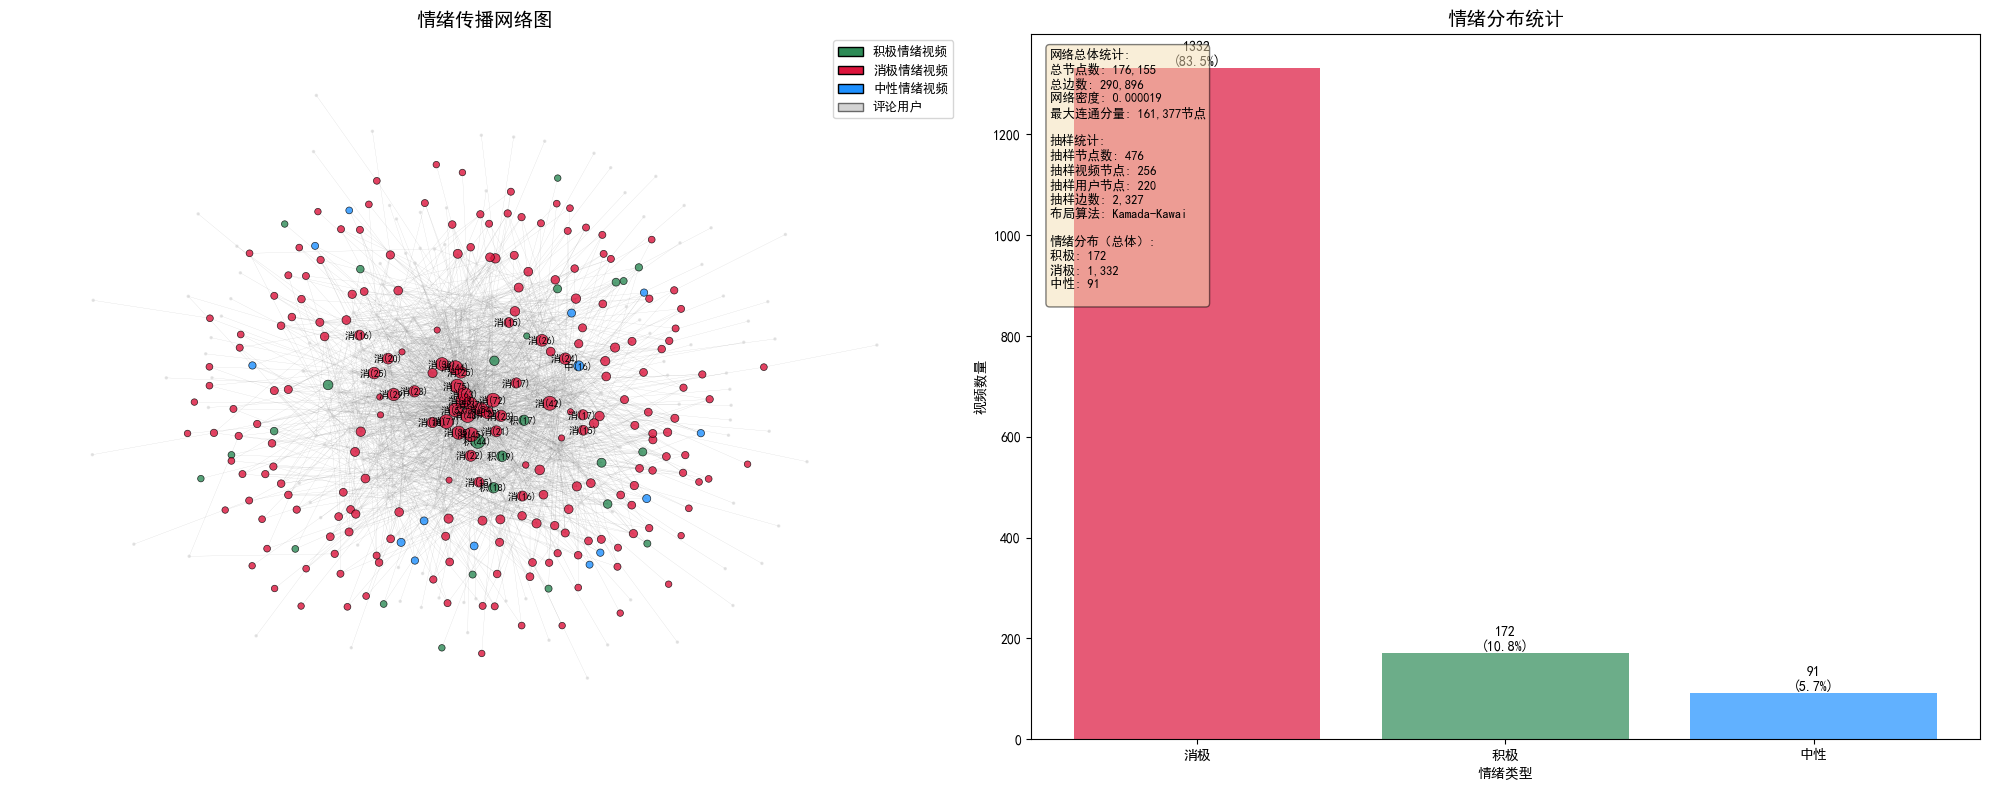


=== 抽样详情 ===
总抽样节点数: 476
抽样视频节点: 256
抽样用户节点: 220
抽样边数: 2327

抽样图中情绪分布:
  消极: 216个视频 (84.4%)
  积极: 26个视频 (10.2%)
  中性: 14个视频 (5.5%)

抽样代表性:
  消极: 原始84.2% → 抽样84.4% (差异: 0.002)
  积极: 原始10.3% → 抽样10.2% (差异: 0.001)
  中性: 原始5.5% → 抽样5.5% (差异: 0.000)

=== 生成网络指标图表 ===
网络指标分析图表已保存为 '网络指标分析图表.png'


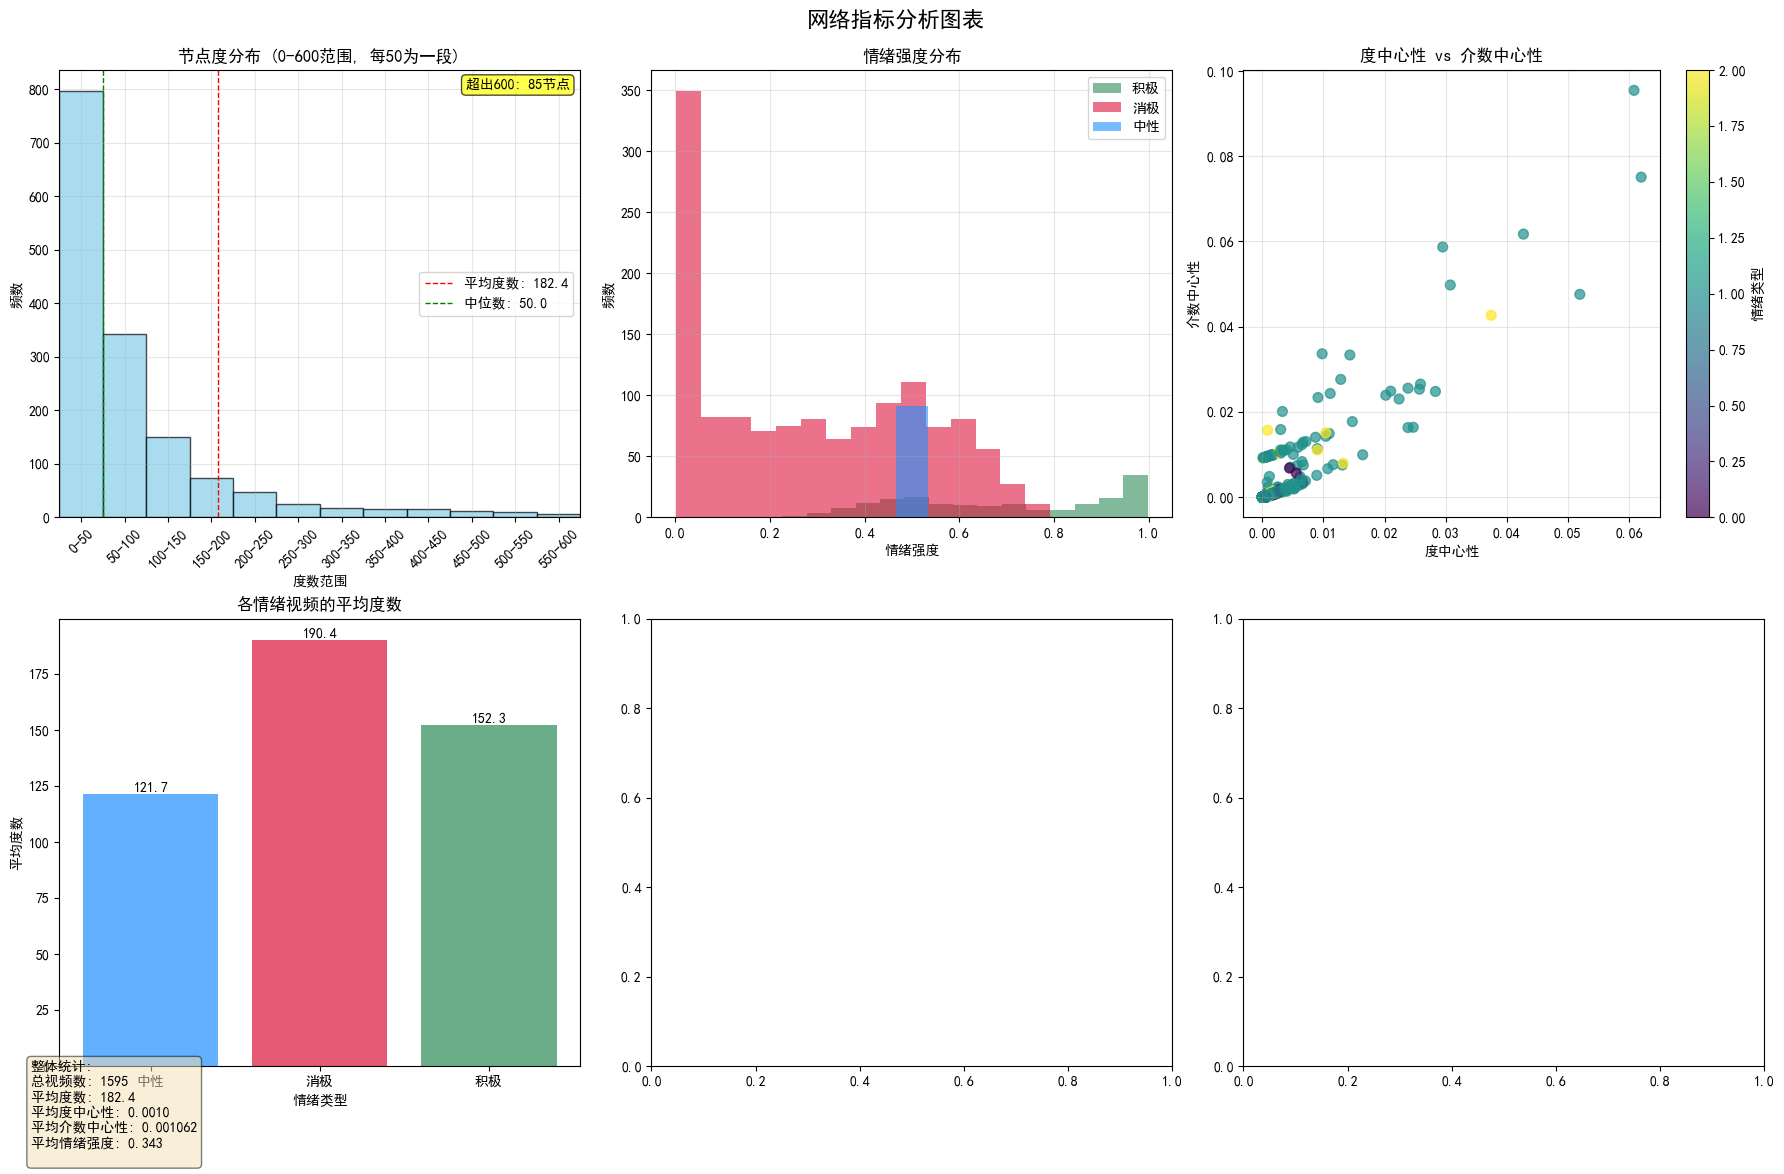


=== 节点度分布统计 (0-600范围) ===
最小度数: 1
最大度数: 10922
平均度数: 182.38
中位数: 50.0
标准差: 674.41

=== 生成不同情绪传播对比图 ===


C:\Users\31596\AppData\Local\Temp\ipykernel_9284\1553407058.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\31596\AppData\Local\Temp\ipykernel_9284\1553407058.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\31596\AppData\Local\Temp\ipykernel_9284\1553407058.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




不同情绪传播对比图已保存为 '不同情绪传播对比图.png'


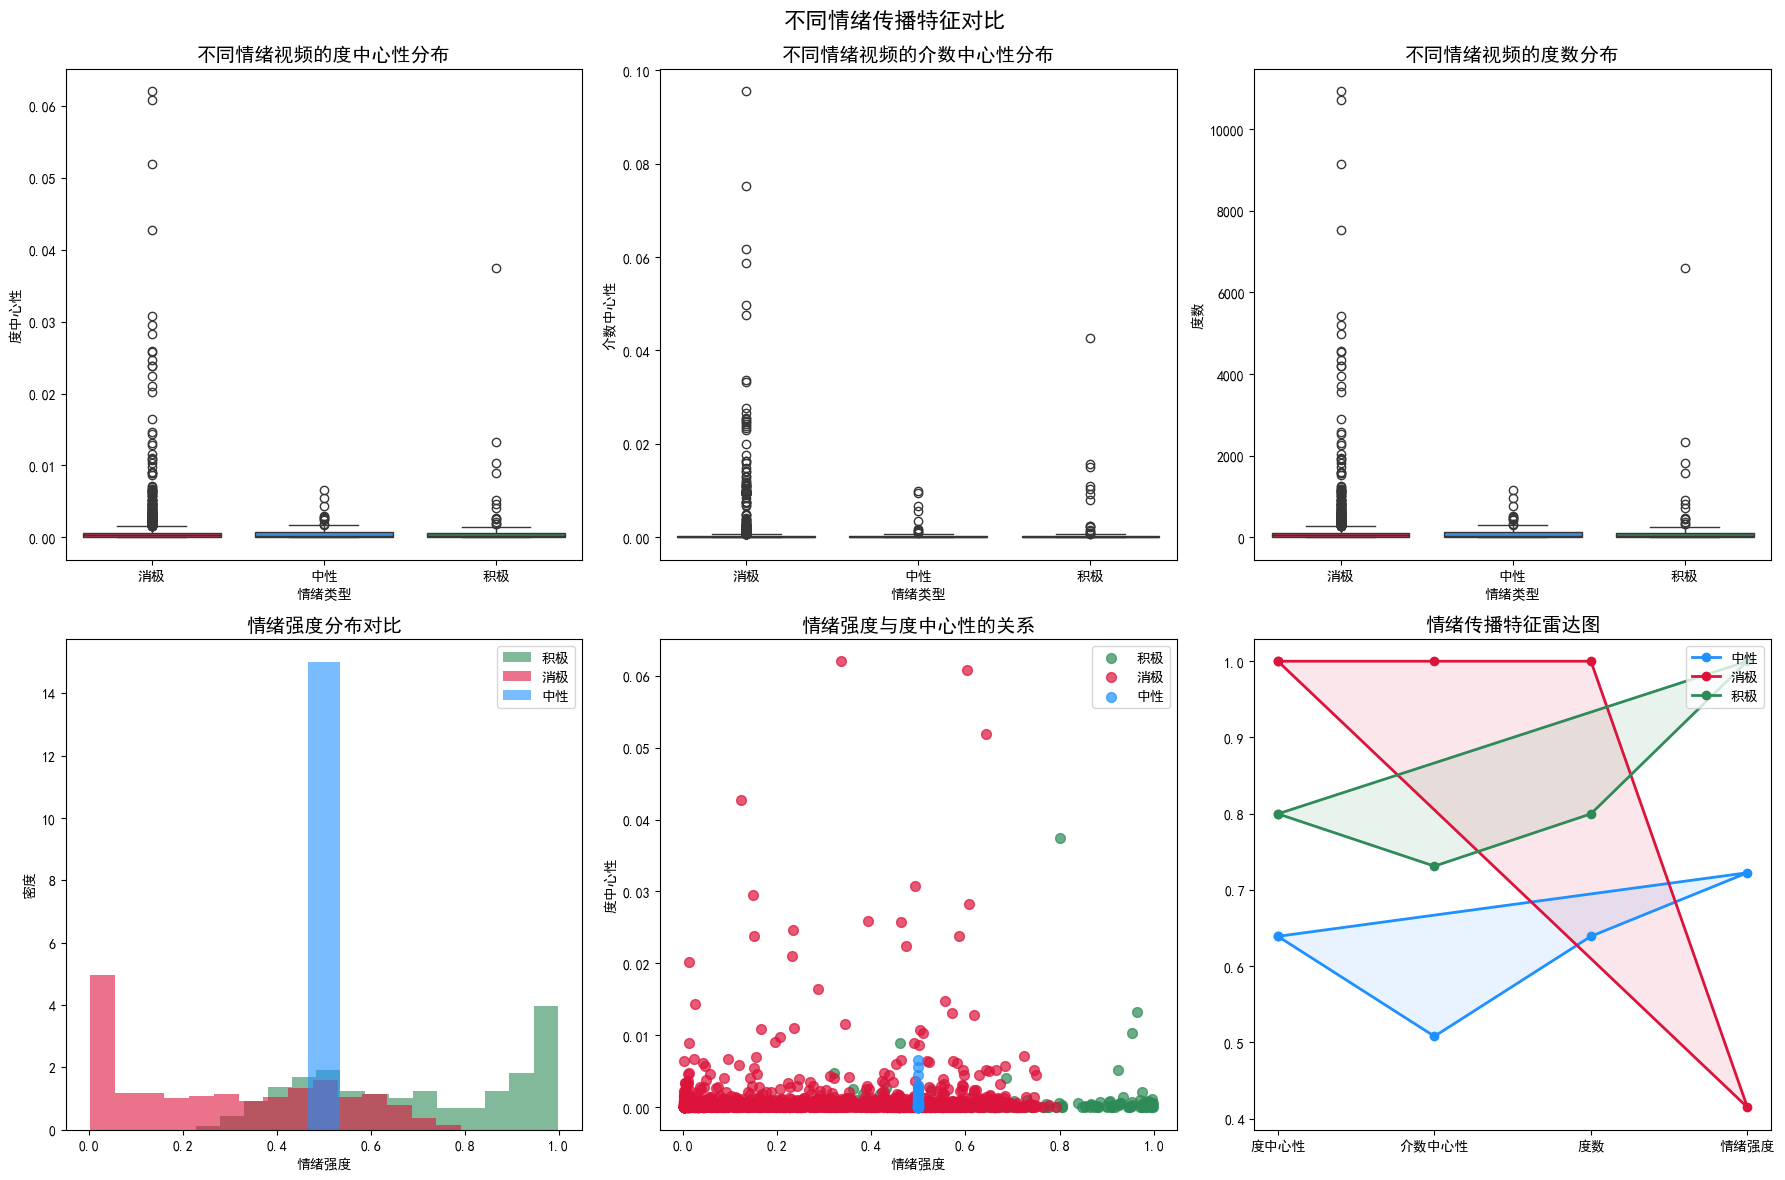


生成交互式情绪传播网络仪表盘...
开始创建交互式网络...
找到 580 个连通分量
最大连通分量包含 161377 个节点
视频节点: 855, 用户节点: 160522
最终采样节点数: 248
检测到 14 个社区
使用Kamada-Kawai布局，节点间距已增加
交互式网络创建成功

情绪传播网络分析完成!
生成的文件:
  - 情绪传播网络图.png
  - 网络指标分析图表.png
  - 不同情绪传播对比图.png
  - 情绪传播网络.gexf (网络数据)
  - 网络指标表.csv (指标数据)
  - 筛选方法评估结果.csv

启动交互式仪表盘...
请在浏览器中访问: http://127.0.0.1:8050/
按 Ctrl+C 停止服务器


开始创建社区视图...
社区视图创建成功


In [40]:
def main():
    """
    主函数：运行完整的情绪传播网络分析流程
    """
    print("开始情绪传播网络分析...")
    
    try:
        # 第一段：数据读取与预处理
        print("数据读取与预处理完成")
        
        # 第二段：构建原始网络图与原始指标表
        G_original, metrics_original = build_original_network_and_metrics(video_df, comment_df)
        
        # 如果原始网络节点过多，进行筛选比较
        if G_original.number_of_nodes() > 300:
            print(f"\n原始网络节点数较多 ({G_original.number_of_nodes()})，进行节点筛选...")
            
            # 第三段：节点筛选比较
            target_nodes = min(300, G_original.number_of_nodes() // 2)
            best_method, G_filtered, metrics_filtered, evaluation_df = compare_node_filtering_methods(
                G_original, metrics_original, target_nodes=target_nodes
            )
            
            print(f"\n使用最佳筛选方法: {best_method}")
            
            # 保存筛选结果
            evaluation_df.to_csv('筛选方法评估结果.csv', index=False, encoding='utf-8-sig')
            print("筛选方法评估结果已保存为 '筛选方法评估结果.csv'")
            
        else:
            print("\n原始网络节点数适中，直接使用原始网络进行分析")
            G_filtered, metrics_filtered = G_original, metrics_original
            best_method = "原始网络"
        
        # 第四段：绘制情绪传播网络图
        network_fig = plot_emotion_propagation_network(G_filtered, metrics_filtered, 
                                                     title=f"情绪传播网络图 ({best_method})")
        
        # 第五段：生成网络指标图表
        metrics_fig = generate_network_metrics_charts(metrics_filtered, metrics_original)
        
        # 第六段：生成不同情绪传播对比图
        comparison_fig = generate_emotion_comparison_plots(metrics_filtered)
        
        # 第七段：生成并启动动态交互图
        print("\n生成交互式情绪传播网络仪表盘...")
        app = create_interactive_network(G_filtered, metrics_filtered, video_df)
        
        print("\n" + "="*60)
        print("情绪传播网络分析完成!")
        print("="*60)
        print("生成的文件:")
        print("  - 情绪传播网络图.png")
        print("  - 网络指标分析图表.png") 
        print("  - 不同情绪传播对比图.png")
        print("  - 情绪传播网络.gexf (网络数据)")
        print("  - 网络指标表.csv (指标数据)")
        if G_original.number_of_nodes() > 300:
            print("  - 筛选方法评估结果.csv")
        print("\n启动交互式仪表盘...")
        print("请在浏览器中访问: http://127.0.0.1:8050/")
        print("按 Ctrl+C 停止服务器")
        print("="*60)
        
        # 启动 Dash 应用
        app.run(port=8050, debug=True)
        
    except Exception as e:
        print(f"分析过程中出现错误: {e}")
        import traceback
        traceback.print_exc()

# 运行主函数
if __name__ == "__main__":
    main()